In [1]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator, LogLocator
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from pathlib import Path
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
import numpy as np
import pandas as pd
import xarray as xr
from cmcrameri import cm as scm
import scipy.fft as fft
import scipy.signal as signal
import scipy.ndimage as ndimage
from scipy import stats

# Pylaeoclim_Leeds v0.0
import pylaeoclim_leeds.hadcm3_processing as hcm3
import pylaeoclim_leeds.zones as zones
import pylaeoclim_leeds.plots as plots
import pylaeoclim_leeds.util_hadcm3 as util

# Meltwater_Protocol v0.0
import mw_protocol.plotting as plotting
import mw_protocol.spreading as spreading
import mw_protocol.glac1d_toolbox as tb

# Millennial-scale climate oscillations triggered by deglacial meltwater discharge in last glacial maximum simulations

Our limited understanding of millennial-scale variability in the context of the last glacial period can be explained by the lack of a reliable modelling framework to study abrupt climate changes under realistic glacial backgrounds. In this article, we describe a new set of long-run Last Glacial Maximum experiments where such climate shifts were triggered by different snapshots of ice-sheet meltwater derived from the early stages of the last deglaciation. Depending on the location and the magnitude of the forcing, we observe three distinct dynamical regimes and highlight a subtle window of opportunity where the climate can sustain oscillations between cold and warm modes. We identify the Eurasian Arctic and Nordic Seas regions as being most sensitive to meltwater discharge in the context of switching to a cold mode, compared to freshwater fluxes from the Laurentide ice sheets. These cold climates follow a consistent pattern in temperature, sea ice and convection, and are largely independent from freshwater release as a result of effective AMOC collapse. Warm modes, on the other hand, show more complexity in their response to the regional pattern of the meltwater input, and within them, we observe significant differences linked to the reorganisation of deep water formation sites and the subpolar gyre. Broadly, the main characteristics of the oscillations, obtained under full-glacial conditions with ice-sheet reconstruction derived meltwater patterns, share similar characteristics with $\delta^{18}O$ records of the last glacial period, although our experiment design prevents detailed conclusions from being drawn on whether these represent actual Dansgaard-Oeschger events. 

## Global variables

In [2]:
# To modify with your data folder. !This does not include GCM outputs.
home_folder = str(Path.home())
data_folder = f"{home_folder}/work/data/publication/ROME2022_paleoceanography_oscillations"

In [3]:
expts = ['xoupa', 'xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']
colors = {'xoupa':'black', 
          'xoupd':'xkcd:bluish green', 'tfgbd':'xkcd:bluish green',
          'xouph':'xkcd:bluey grey', 
          'xoupf':'xkcd:velvet', 
          'tfgbi':'xkcd:bluish',
          'xoupl':'xkcd:burnt orange', 'tfgbr':'xkcd:burnt orange',
          'tfgbj':'xkcd:light orange'}
labels = {'xoupa':'CTRL', 'tfgbd':'21.5k', 'xoupd':'21.5k', 'xouph':'21k', 'tfgbi':'20.7k', 'tfgbr':'19.4k', 'xoupl':'19.4k', 'xoupf':'18.2k', 'tfgbj':'17.8k'}
snapshots = {'tfgbd':21.5, 'xoupd':21.5, 'xouph':21, 'tfgbi':20.7, 'tfgbr':19.4, 'xoupl':19.4, 'xoupf':18.2, 'tfgbj':17.8}
start_dates = {'xoupa':-1000, 'tfgbd':0, 'xoupd':0, 'xouph':0, 'tfgbi':0, 'tfgbr':0, 'xoupl':0, 'xoupf':0, 'tfgbj':0}
smooth_date = {'xoupa':3800, 'xoupd':4060-1000, 'xoupf':9900-1000, 'xouph':3650-1000, 'xoupl':9610-1000}

In [4]:
lon_na_min, lon_na_max, lat_na_min, lat_na_max = 290, 370, 45, 80
zone_na = util.cycle_box(lon_na_min, lon_na_max, lat_na_min, lat_na_max)
box_na = zones.Box(lon_na_min, lon_na_max, lat_na_min, lat_na_max, z_min = -1000)
plane_na = zones.Box(lon_na_min, lon_na_max, lat_na_min, lat_na_max)

lon_esp_min, lon_esp_max, lat_esp_min, lat_esp_max = 335, 350, 45, 55
zone_esp = util.cycle_box(lon_esp_min, lon_esp_max, lat_esp_min, lat_esp_max)
box_esp = zones.Box(lon_esp_min, lon_esp_max, lat_esp_min, lat_esp_max, z_min = -1000)
plane_esp = zones.Box(lon_esp_min, lon_esp_max, lat_esp_min, lat_esp_max)

In [5]:
reader = shpreader.Reader(f"{data_folder}/shapefiles/landmassLGMPolygon2.shp")
lgm = [obj for obj in reader.records()][1]
lgm_feature = ShapelyFeature([lgm.geometry], ccrs.PlateCarree(), facecolor="xkcd:pale", edgecolor='black', lw=0.4)
lgm_coastline = ShapelyFeature([lgm.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.5)

## Methods

### Figure 1 - Meltwater Discharge Protocol

In [6]:
ds_discharge = xr.open_dataset(f"{data_folder}/mw_inputs/xoup.wfix.glac_ts.nc",decode_times=False)
ds_lsm = xr.open_dataset(f"{data_folder}/lgm_inputs/temev.qrparm.omask.nc")
ds_wfix = xr.open_dataset(f"{data_folder}/lgm_inputs/qrparm.waterfix.hadcm3.nc")

flux = plotting.create_discharge_ts(ds_discharge, ds_lsm, ds_wfix, unit="kg/m2/s")
t = ds_discharge.t.values

flux_nea = flux['nea']
flux_gin = flux['egi'] + flux['nsbi']
flux_med = flux['med']
flux_arc = flux['larc'] + flux['garc'] + flux['earc']
flux_so = flux['so']
flux_pac = flux['pac']
flux_tot = flux['tot']

<generator object create_discharge_ts.<locals>.<genexpr> at 0x2ac482bb9580>


In [7]:
lon_lsm, lat_lsm, depth, lsm = ds_lsm.longitude.values, ds_lsm.latitude.values, ds_lsm.depthdepth.values, ds_lsm.lsm.values
masked = np.copy(lsm)  # land mask True (1) on land
depthm = np.ma.masked_less(depth, 500.0)  # mask areas shallower than 500m
masked_500m = np.copy(depthm.mask) + masked  # create binary mask from depth data
lat, lon = spreading.LatAxis(lat_lsm[:]), spreading.LonAxis(lon_lsm[:])
umgrid = spreading.Grid(lat, lon)

cb = spreading.generate_collection_boxes()
sr = spreading.generate_spreading_regions(cb, umgrid, masked, masked_500m)

In [8]:
wfix = ds_wfix.field672.isel(t=0).isel(depth=0)
lon = ds_wfix.longitude.values
lat = ds_wfix.latitude.values

mw_215 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix
mw_21 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm1.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix
mw_207 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm2.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix
mw_194 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm_na.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix
mw_182 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm_arc.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix
mw_178 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm_arc2.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


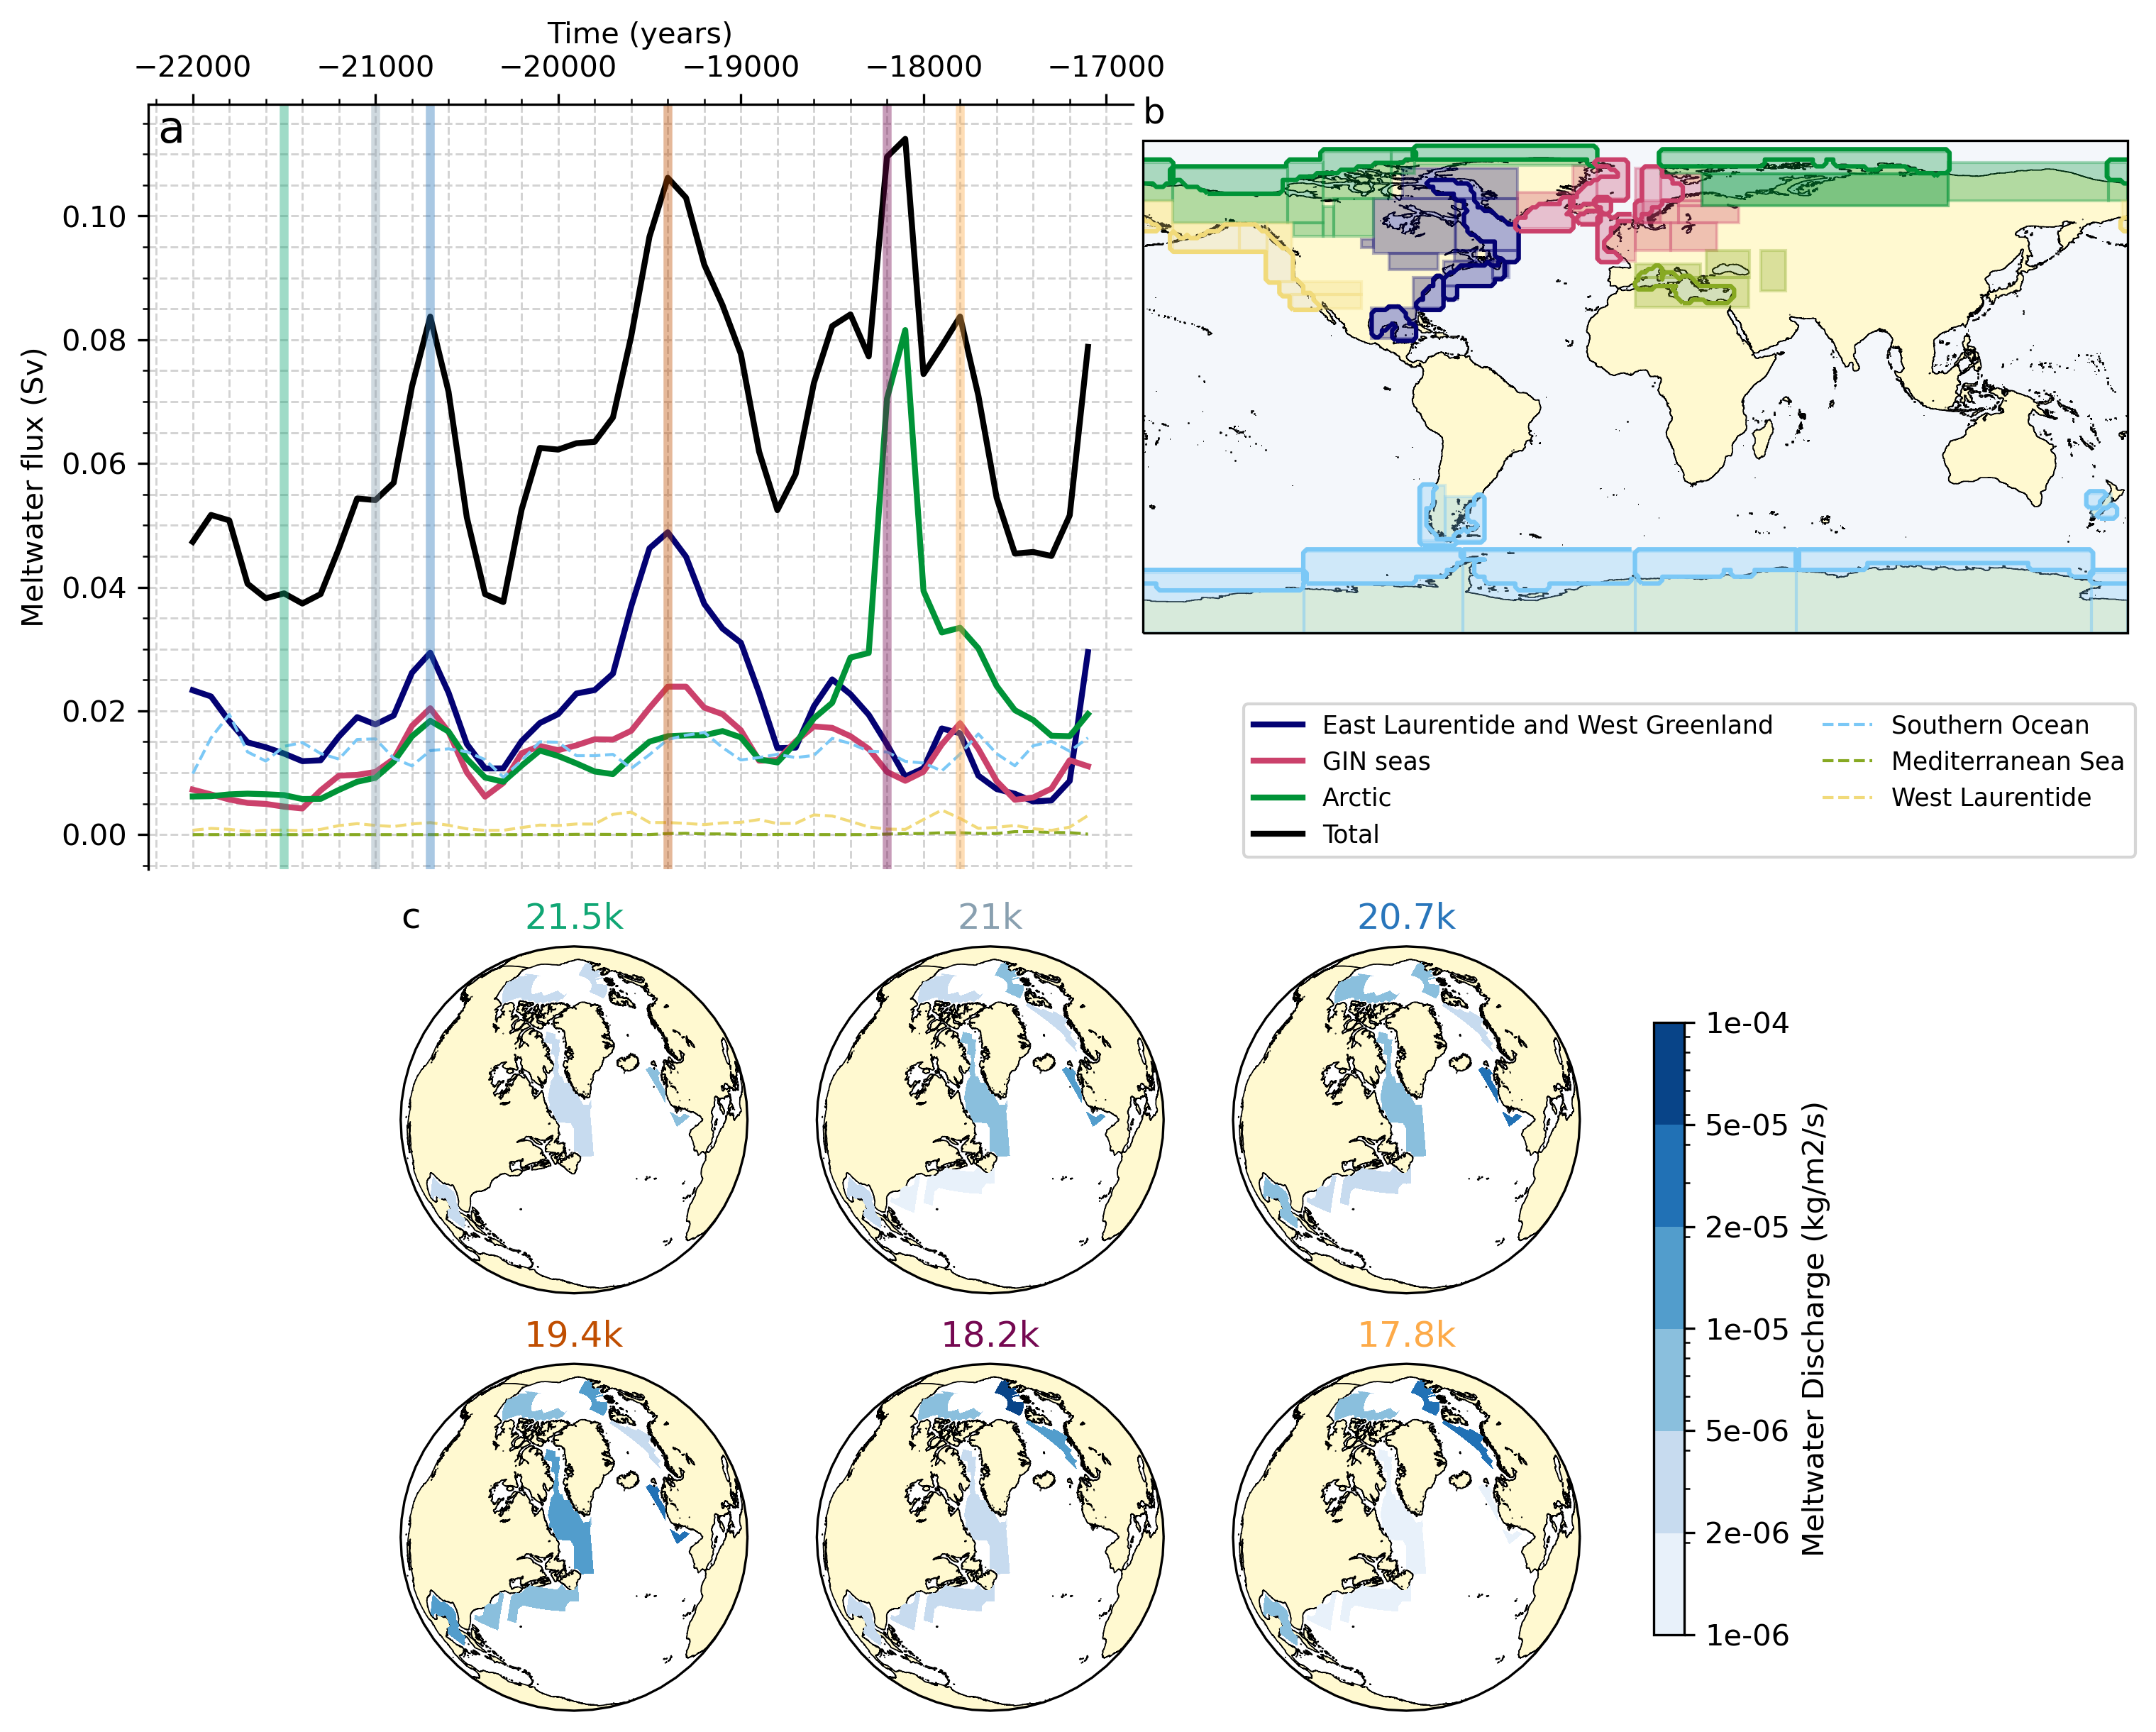

In [9]:
figMap = plt.figure(figsize=(12,10), dpi=300)

grid = figMap.add_gridspec(2, 8, hspace=0.1)

gridup = gridspec.GridSpecFromSubplotSpec(4, 2, wspace=0.01, width_ratios=[1,1], subplot_spec=grid[0,:])
projection_map = ccrs.PlateCarree()
axTs = figMap.add_subplot(gridup[:,0])
axMap = figMap.add_subplot(gridup[0:3,1], projection = projection_map)

griddown = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=grid[1,1:7])
projection_map = ccrs.NearsidePerspective(central_longitude=-50.0, central_latitude=55.0, satellite_height=10000000)
axLGMMin= figMap.add_subplot(griddown[0,0], projection = projection_map)
axLGM = figMap.add_subplot(griddown[0,1], projection = projection_map)
axLGMMax = figMap.add_subplot(griddown[0,2], projection = projection_map)
axNA = figMap.add_subplot(griddown[1,0], projection = projection_map)
axARC = figMap.add_subplot(griddown[1,1], projection = projection_map)
axARCMin = figMap.add_subplot(griddown[1,2], projection = projection_map)

colors_region = {'elwg': 'xkcd:deep blue', 'gin':'xkcd:dark pink', 'med':'xkcd:avocado green', 'arc':'xkcd:kelley green', 
                'so':'xkcd:lightblue', 'wl':'xkcd:sandy', 'tot':'xkcd:black'}

# Time series 

start, end = 40, 90

axTs.plot(t[start:end], util.running_mean(flux_nea[start:end],2), label="East Laurentide and West Greenland",
          color=colors_region['elwg'], linestyle="-", linewidth=2)
axTs.plot(t[start:end], util.running_mean(flux_gin[start:end],2), label="GIN seas", 
          color=colors_region['gin'], linestyle="-", linewidth=2)
axTs.plot(t[start:end], util.running_mean(flux_arc[start:end],2), label="Arctic",
          color=colors_region['arc'], linestyle="-", linewidth=2)
axTs.plot(t[start:end], util.running_mean(flux_tot[start:end],2), label="Total",
          color=colors_region['tot'], linestyle="-", linewidth=2)
axTs.plot(t[start:end], util.running_mean(flux_so[start:end],2), label="Southern Ocean",
          color=colors_region['so'], linestyle="--", linewidth=1)
axTs.plot(t[start:end], util.running_mean(flux_med[start:end],2), label="Mediterranean Sea",
          color=colors_region['med'], linestyle="--", linewidth=1)
axTs.plot(t[start:end], util.running_mean(flux_pac[start:end],2), label="West Laurentide",
          color=colors_region['wl'], linestyle="--", linewidth=1)
axTs.axvline(x=-21500, color=colors['xoupd'], linewidth=3, alpha=0.4)
axTs.axvline(x=-21000, color=colors['xouph'], linewidth=3, alpha=0.4)
axTs.axvline(x=-20700, color=colors['tfgbi'], linewidth=3, alpha=0.4)
axTs.axvline(x=-19400, color=colors['xoupl'], linewidth=3, alpha=0.4)
axTs.axvline(x=-18200, color=colors['xoupf'], linewidth=3, alpha=0.4)
axTs.axvline(x=-17800, color=colors['tfgbj'], linewidth=3, alpha=0.4)
axTs.legend(loc="lower left", fontsize='small', bbox_to_anchor=(1.1, 0, 1, 1), ncol=2)
axTs.spines['right'].set_visible(False)
axTs.spines['bottom'].set_visible(False)
axTs.xaxis.set_ticks_position('top')
axTs.xaxis.set_label_position('top')
axTs.set_xlabel("Time (years)")
axTs.set_ylabel("Meltwater flux (Sv)")
axTs.minorticks_on()
axTs.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.7)
axTs.annotate('a', xy=(0.01,0.95), xycoords='axes fraction', size=15)


# COLLECTION BOXES

# East Laurentide and West Greenland

axMap.fill(cb['USECoast1'].cycle_box()[0], cb['USECoast1'].cycle_box()[1], color=colors_region['elwg'],
           linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="East Laurentide and West Greenland")
for region in ['USECoast2', 'USECoast3', 'USECoast4', 'USECoast5', 'USECoast6', 'GrLakes1', 'GoM1', 'BafLab1',
               'BafLab2', 'BafLab3', 'HudBay1', 'HudBay2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['elwg'], linestyle = "-",
               alpha=0.3, transform=ccrs.PlateCarree())

# GIN seas

axMap.fill(cb['AtlGr1'].cycle_box()[0], cb['AtlGr1'].cycle_box()[1], color=colors_region['gin'], linestyle = "-", 
           alpha=0.3, transform=ccrs.PlateCarree(), label="GIN seas")
for region in ['EGrIce1', 'EGrIce2', 'EIceland1', 'SIceland1', 'UKAtl1', 'EurGIN1', 'EurGIN2', 'EurGIN3', 'EurGIN4',
               'EurGIN5', 'EurGIN6', 'Baltic1', 'Baltic2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['gin'], linestyle = "-",
               alpha=0.3, transform=ccrs.PlateCarree())
    
# Arctic

axMap.fill(cb['GrArc1'].cycle_box()[0], cb['GrArc1'].cycle_box()[1], color=colors_region['arc'], linestyle = "-",
           alpha=0.3, transform=ccrs.PlateCarree(), label="Arctic")
for region in ['NAMArc1', 'NAMArc2', 'NAMArc3', 'NAMArc4', 'NAMArc5', 'NWTerr1', 'NWTerr2', 'SibArc1',
               'SibArc2', 'EurArc1', 'EurArc2', 'EurArc2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['arc'], linestyle = "-", 
               alpha=0.3, transform=ccrs.PlateCarree())

# Souther ocean

axMap.fill(cb['PatAtl1'].cycle_box()[0], cb['PatAtl1'].cycle_box()[1], color=colors_region['so'], linestyle = "-", 
           alpha=0.3, transform=ccrs.PlateCarree(), label="Southern Ocean")
for region in ['PatPac1', 'PatPac2', 'AARos1', 'AAAmund', 'AAWeddell', 'AARiiLar', 'AADavis', 'SNZPac1', 'NNZPac1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['so'], linestyle = "-",
               alpha=0.3, transform=ccrs.PlateCarree())

# Pacific

axMap.fill(cb['EPac1'].cycle_box()[0], cb['EPac1'].cycle_box()[1], color=colors_region['wl'], linestyle = "-", 
           alpha=0.3, transform=ccrs.PlateCarree(), label="Pacific")
for region in ['EPac2', 'EPac3', 'EPac4', 'EPac5', 'RussPac1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['wl'], linestyle = "-", 
               alpha=0.3, transform=ccrs.PlateCarree())

# Mediterannean Sea

axMap.fill(cb['Med1'].cycle_box()[0], cb['Med1'].cycle_box()[1], color=colors_region['med'], linestyle = "-", alpha=0.3,
           transform=ccrs.PlateCarree(), label="Mediterranean Sea")
for region in ['Med2', 'BlckSea1', 'CaspSea1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['med'], linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())

    
# SPREADING REGIONDS

for region in sr:
    if region['name'] in ['US_East_Coast', 'Gulf_of_Mexico', 'LabradorSea_BaffinBay']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, 
                      levels=[True], colors=colors_region['elwg'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Greenland_Arctic', 'N_American_Arctic', 'Eurasian_Arctic', 'Siberian_Arctic']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['arc'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['East_Pacific', 'Russia_Pacific']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['wl'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Atlantic_GreenlandIceland', 'EastGreenland_Iceland', 'EastIceland']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['gin'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['UK_Atlantic', 'Eurasian_GINSeas', 'South_Iceland']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['gin'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Mediterranean']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['med'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Patagonia_Atlantic', 'Patagonia_Pacific', 'NorthNewZealand_Pacific', 'SouthNewZealand_Pacific', 'Antarctica_RossSea', 'Antarctica_AmundsenSea', 'Antarctica_WeddellSea', 'Antarctica_RiiserLarsonSea', 'Antarctica_DavisSea']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, 
                      levels=[True], colors=colors_region['so'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)

axMap.set_global()
axMap.add_feature(lgm_feature, zorder=0)
# axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axMap.add_feature(cartopy.feature.OCEAN, zorder=-1, edgecolor='black', lw=0, alpha=0.1)
axMap.set_title('b', loc='left')


# MELWATER DISCHARGE PANNELS

bounds = np.array([10**(-6), 2*10**(-6), 5*10**(-6), 10**(-5), 2*10**(-5), 5*10**(-5), 10**(-4)])
norm = mpl.colors.Normalize(vmin=0, vmax=10**(-4))

axLGMMin.contourf(lon, lat, mw_215, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axLGMMin.set_title("21.5k", color=colors['xoupd'])
axLGMMin.set_title('c', loc='left')

axLGM.contourf(lon, lat, mw_21, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axLGM.set_title("21k", color=colors['xouph'])

axLGMMax.contourf(lon, lat, mw_207, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axLGMMax.set_title("20.7k", color=colors['tfgbi'])

axNA.contourf(lon, lat, mw_194, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axNA.set_title("19.4k", color=colors['xoupl'])

cm = axARC.contourf(lon, lat, mw_182, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axARC.set_title("18.2k", color=colors['xoupf'])

axARCMin.contourf(lon, lat, mw_178, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axARCMin.set_title("17.8k", color=colors['tfgbj'])

for ax in [axLGMMin, axLGM, axLGMMax, axNA, axARC, axARCMin]:
    ax.set_global()
    ax.add_feature(lgm_feature, zorder=0)

figMap.colorbar(mappable=cm, ax=[axLGMMin, axLGM, axLGMMax, axNA, axARC, axARCMin], ticks = bounds, shrink=0.8, format='%.0e', label="Meltwater Discharge (kg/m2/s)")


In [10]:
# figMap.savefig('Figures/protocol.pdf', bbox_extra_artists=(), bbox_inches='tight', format='pdf')

## Results

### Figure 2 - Control simulation

In [11]:
start_ctrl, end_ctrl = 4900, 4999
zone_na = zones.Box(lat_min=0)

ts = hcm3.SATATS("xoupa", start_ctrl, end_ctrl, chunks=100)
sat_ctrl = ts.sat(mode_t="mean", zone=zone_na)
lon_at, lat_at = sat_ctrl.lon_p, sat_ctrl.lat_p

ts = hcm3.MLDATS("xoupa", start_ctrl, end_ctrl, chunks=100)
mld_ctrl = ts.mld(mode_t="mean", zone=zone_na)
mld_values = mld_ctrl.values()
mld_values[-1] = mld_values[-2]
ts = hcm3.SSTATS("xoupa", start_ctrl, end_ctrl, chunks=100)
sst_ctrl = ts.sst(mode_t="mean", zone=zone_na)
sst_values = sst_ctrl.values()
sst_values[-1] = sst_values[-2]
lon_ocn, lat_ocn = mld_ctrl.lon_p, mld_ctrl.latb_p

ts = hcm3.WICEATS("xoupa", start_ctrl, end_ctrl, chunks=100)
wice_ctrl = ts.ice_conc(mode_t="mean")
ts = hcm3.SICEATS("xoupa", start_ctrl, end_ctrl, chunks=100)
sice_ctrl = ts.ice_conc(mode_t="mean")
lon_ice, lat_ice = wice_ctrl.lon_p, wice_ctrl.lat_p

ts = hcm3.MERIDATS("xoupa", start_ctrl, end_ctrl, chunks=100)
amoc_ctrl = ts.atlantic(zone=zones.Box(lat_min=-10), mode_t="mean")
lat_moc, z_moc = amoc_ctrl.lat, amoc_ctrl.z_p

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MLDATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SSTATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SST.
____ Coordinates imported in the GeoDataArray instance.
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.WICEATS'>

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Processing t: mean
____ Rebuilding the data_array


/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(-0.3, 0.95, 'd')

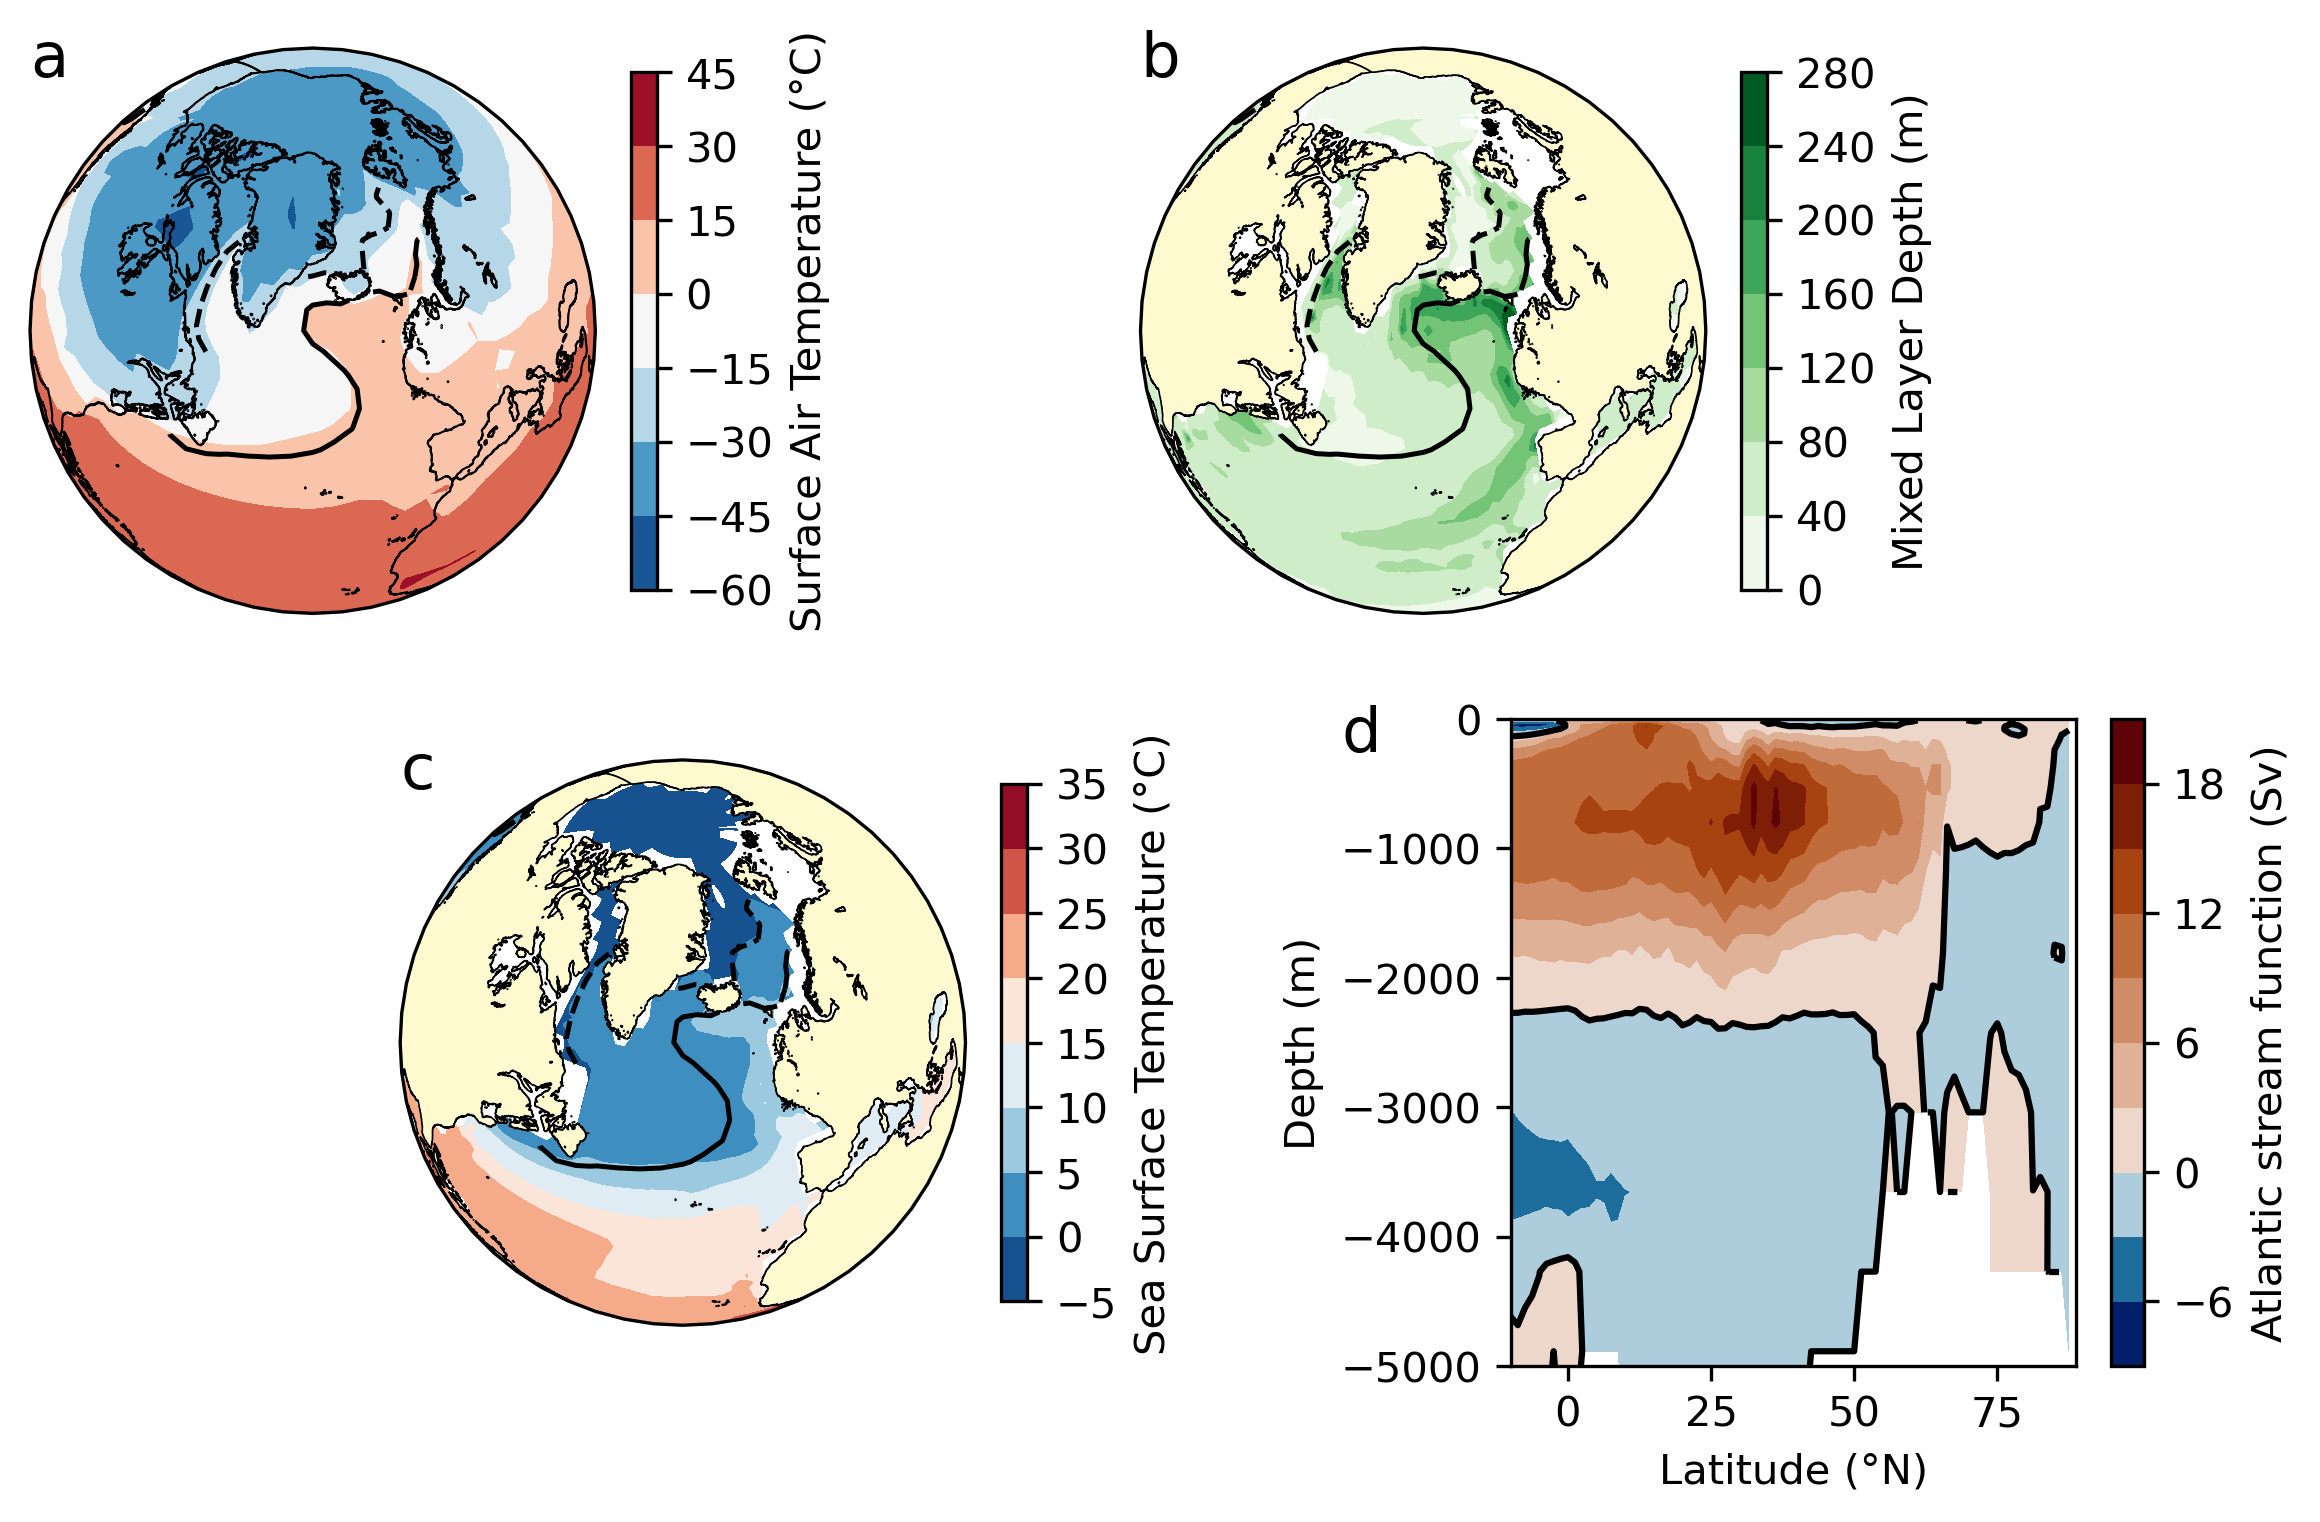

In [12]:
figMap = plt.figure(figsize=(11,6), dpi=300)
projection_map = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=60, satellite_height=7000000)

gs = gridspec.GridSpec(nrows=2, ncols=7, wspace=0.1, hspace=0.1)
axSAT = figMap.add_subplot(gs[0,0:2], projection = projection_map)
axMLD = figMap.add_subplot(gs[0,3:5], projection = projection_map)
axSST = figMap.add_subplot(gs[1,1:3], projection = projection_map)
axAMOC = figMap.add_subplot(gs[1,4:6])

# SAT

cmSAT = axSAT.contourf(lon_at, lat_at, sat_ctrl.values(), transform=ccrs.PlateCarree(), cmap="RdBu_r")
axSAT.contour(lon_ice, lat_ice, wice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='-')
axSAT.contour(lon_ice, lat_ice, sice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='--')
axSAT.set_global()
axSAT.add_feature(lgm_coastline, zorder=1)
figMap.colorbar(mappable=cmSAT, ax=axSAT, label="Surface Air Temperature (°C)", shrink=0.8)

# SST

cmSST = axSST.contourf(lon_ocn, lat_ocn, sst_values, transform=ccrs.PlateCarree(), cmap="RdBu_r")
axSST.contour(lon_ice, lat_ice, wice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='-')
axSST.contour(lon_ice, lat_ice, sice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='--')
axSST.set_global()
axSST.add_feature(lgm_feature, zorder=1)
figMap.colorbar(mappable=cmSST, ax=axSST, label="Sea Surface Temperature (°C)", shrink=0.8)

# MLD

cmMLD = axMLD.contourf(lon_ocn, lat_ocn, mld_values, transform=ccrs.PlateCarree(), cmap="Greens")
axMLD.contour(lon_ice, lat_ice, wice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='-')
axMLD.contour(lon_ice, lat_ice, sice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='--')
axMLD.set_global()
axMLD.add_feature(lgm_feature, zorder=1)
figMap.colorbar(mappable=cmMLD, ax=axMLD, label="Mixed Layer Depth (m)", shrink=0.8)

# AMOC
norm = mpl.colors.TwoSlopeNorm(vmin=-8, vcenter=0, vmax=20)
cmAMOC = axAMOC.contourf(lat_moc, z_moc, amoc_ctrl.values(), cmap=scm.vik, norm=norm, levels=8)
axAMOC.contour(lat_moc, z_moc, amoc_ctrl.values(), levels=[0], colors='black')
axAMOC.set_xlabel("Latitude (°N)")
axAMOC.set_ylabel("Depth (m)")
axAMOC.set_ylim([-5000,0])
figMap.colorbar(mappable=cmAMOC, ax=axAMOC, label="Atlantic stream function (Sv)")

axSAT.annotate('a', xy=(0, 0.95), xycoords='axes fraction', size=15)
axMLD.annotate('b', xy=(0, 0.95), xycoords='axes fraction', size=15)
axSST.annotate('c', xy=(0, 0.95), xycoords='axes fraction', size=15)
axAMOC.annotate('d', xy=(-0.3, 0.95), xycoords='axes fraction', size=15)

In [13]:
# figMap.savefig('Figures/control.pdf', bbox_inches='tight', format='pdf')

### Text - Global temperature changes

In [14]:
start_ctrl, end_ctrl = 4900, 4999

ts = hcm3.SATATS("xoupa", start_ctrl, end_ctrl)
sat_mean = ts.sat(mode_t="mean", mode_lon="weighted_mean", mode_lat="weighted_mean").values()
ts = hcm3.SSTATS("xoupa", start_ctrl, end_ctrl)
sst_mean = ts.sst(mode_t="mean", mode_lon="weighted_mean", mode_lat="weighted_mean").values()

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: weighted_mean
____ Processing latitude: weighted_mean
____ Processing t: mean
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SSTATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SST.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: weighted_mean
____ Processing latitude: weighted_mean
____ Processing t: mean


In [15]:
da = xr.open_dataset(f"{data_folder}/pi_climate/temeaa.pdclann.nc").temp_mm_srf
lat_weights = np.cos(np.deg2rad(da.latitude))
weights = da.weighted(lat_weights)
da = weights.mean("latitude")
sat_pi = da.isel(t=0).isel(surface=0).mean(dim="longitude").values - 273.15

da = xr.open_dataset(f"{data_folder}/pi_climate/temeao.pfclann.nc").temp_mm_uo
lat_weights = np.cos(np.deg2rad(da.latitude))
weights = da.weighted(lat_weights)
da = weights.mean("latitude")
sst_pi = da.isel(t=0).isel(unspecified=0).mean(dim="longitude").values

In [16]:
print(f"Global surface air temperature change : {sat_mean - sat_pi:.2f} °C")

Global surface air temperature change : -6.62 °C


In [17]:
print(f"Global sea surface temperature change : {sst_mean - sst_pi:.2f} °C")

Global sea surface temperature change : -3.42 °C


### Figure 3 - AMOC response to meltwater input

In [18]:
amoc, ngrip, epica, precip, itcz_index ={}, {}, {}, {}, {}

for expt in ['xoupa', 'tfgbi', 'tfgbj', 'xoupf', 'xouph']:
    amoc[expt] = hcm3.MERIDATS(expt, chunks=10).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
    ngrip[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
    epica[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=-75, mode_lon="value", value_lon = 123)
    precip[expt] = hcm3.PRECIPATS(expt, chunks=10).precip()
    itcz_index[expt] = np.nanmean(util.calculate_itcz_lon_index(precip[expt]), axis=1)

amoc['xoupl'] = hcm3.MERIDATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.MERIDATS('xoupl', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
amoc['xoupd'] = hcm3.MERIDATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.MERIDATS('xoupd', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
ngrip['xoupl'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
ngrip['xoupd'] = hcm3.SATATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.SATATS('xoupd', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
epica['xoupl'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=-75, mode_lon="value", value_lon = 123)
epica['xoupd'] = hcm3.SATATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.SATATS('xoupd', chunks=10)).sat(mode_lat="value", value_lat=-75, mode_lon="value", value_lon = 123)
precip['xoupl'] = hcm3.PRECIPATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.PRECIPATS('xoupl', chunks=10)).precip()
precip['xoupd'] = hcm3.PRECIPATS('tfgbr', end_year=4060, chunks=10).concat(hcm3.PRECIPATS('xoupd', chunks=10)).precip()
itcz_index['xoupl'] = np.nanmean(util.calculate_itcz_lon_index(precip['xoupl']), axis=1)
itcz_index['xoupd'] = np.nanmean(util.calculate_itcz_lon_index(precip['xoupd']), axis=1)

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupa between years 1 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longi

/nfs/see-fs-01_users/eeymr/work/scripts/pylaeoclim_leeds/util_hadcm3.py:543: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbi between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
__

/nfs/see-fs-01_users/eeymr/work/scripts/pylaeoclim_leeds/util_hadcm3.py:543: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
__

/nfs/see-fs-01_users/eeymr/work/scripts/pylaeoclim_leeds/util_hadcm3.py:543: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupf between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupf between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupf between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
__

/nfs/see-fs-01_users/eeymr/work/scripts/pylaeoclim_leeds/util_hadcm3.py:543: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xouph between years 1001 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xouph between years 1000 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xouph between years 1000 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ 

/nfs/see-fs-01_users/eeymr/work/scripts/pylaeoclim_leeds/util_hadcm3.py:543: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbr between years 1001 and 3999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupl between years 4001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbd between years 1001 and 4060.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupd between years 4061 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic

/nfs/see-fs-01_users/eeymr/work/scripts/pylaeoclim_leeds/util_hadcm3.py:543: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


In [19]:
ds_discharge = xr.open_dataset(f"{data_folder}/mw_inputs/xoup.wfix.glac_ts.nc",decode_times=False)
ds_lsm = xr.open_dataset(f"{data_folder}/lgm_inputs/temev.qrparm.omask.nc")
ds_wfix = xr.open_dataset(f"{data_folder}/lgm_inputs/qrparm.waterfix.hadcm3.nc")

ts = plotting.create_discharge_ts(ds_discharge, ds_lsm, ds_wfix, unit="kg/m2/s", running_mean=2)
t = ds_discharge.t.values

index, total, na, arc, gin = {}, {}, {}, {}, {}
for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    index[expt] = np.where(t==-float(snapshots[expt])*1000)
    total[expt] = ts['tot'][index[expt]][0]
    na[expt] = ts['nea'][index[expt]][0]
    arc[expt] = ts['larc'][index[expt]][0] + ts['garc'][index[expt]][0] + ts['earc'][index[expt]][0]
    gin[expt] = ts['egi'][index[expt]][0] + ts['nsbi'][index[expt]][0]


<generator object create_discharge_ts.<locals>.<genexpr> at 0x2ac482bb9270>


Text(0.01, 0.85, 'e')

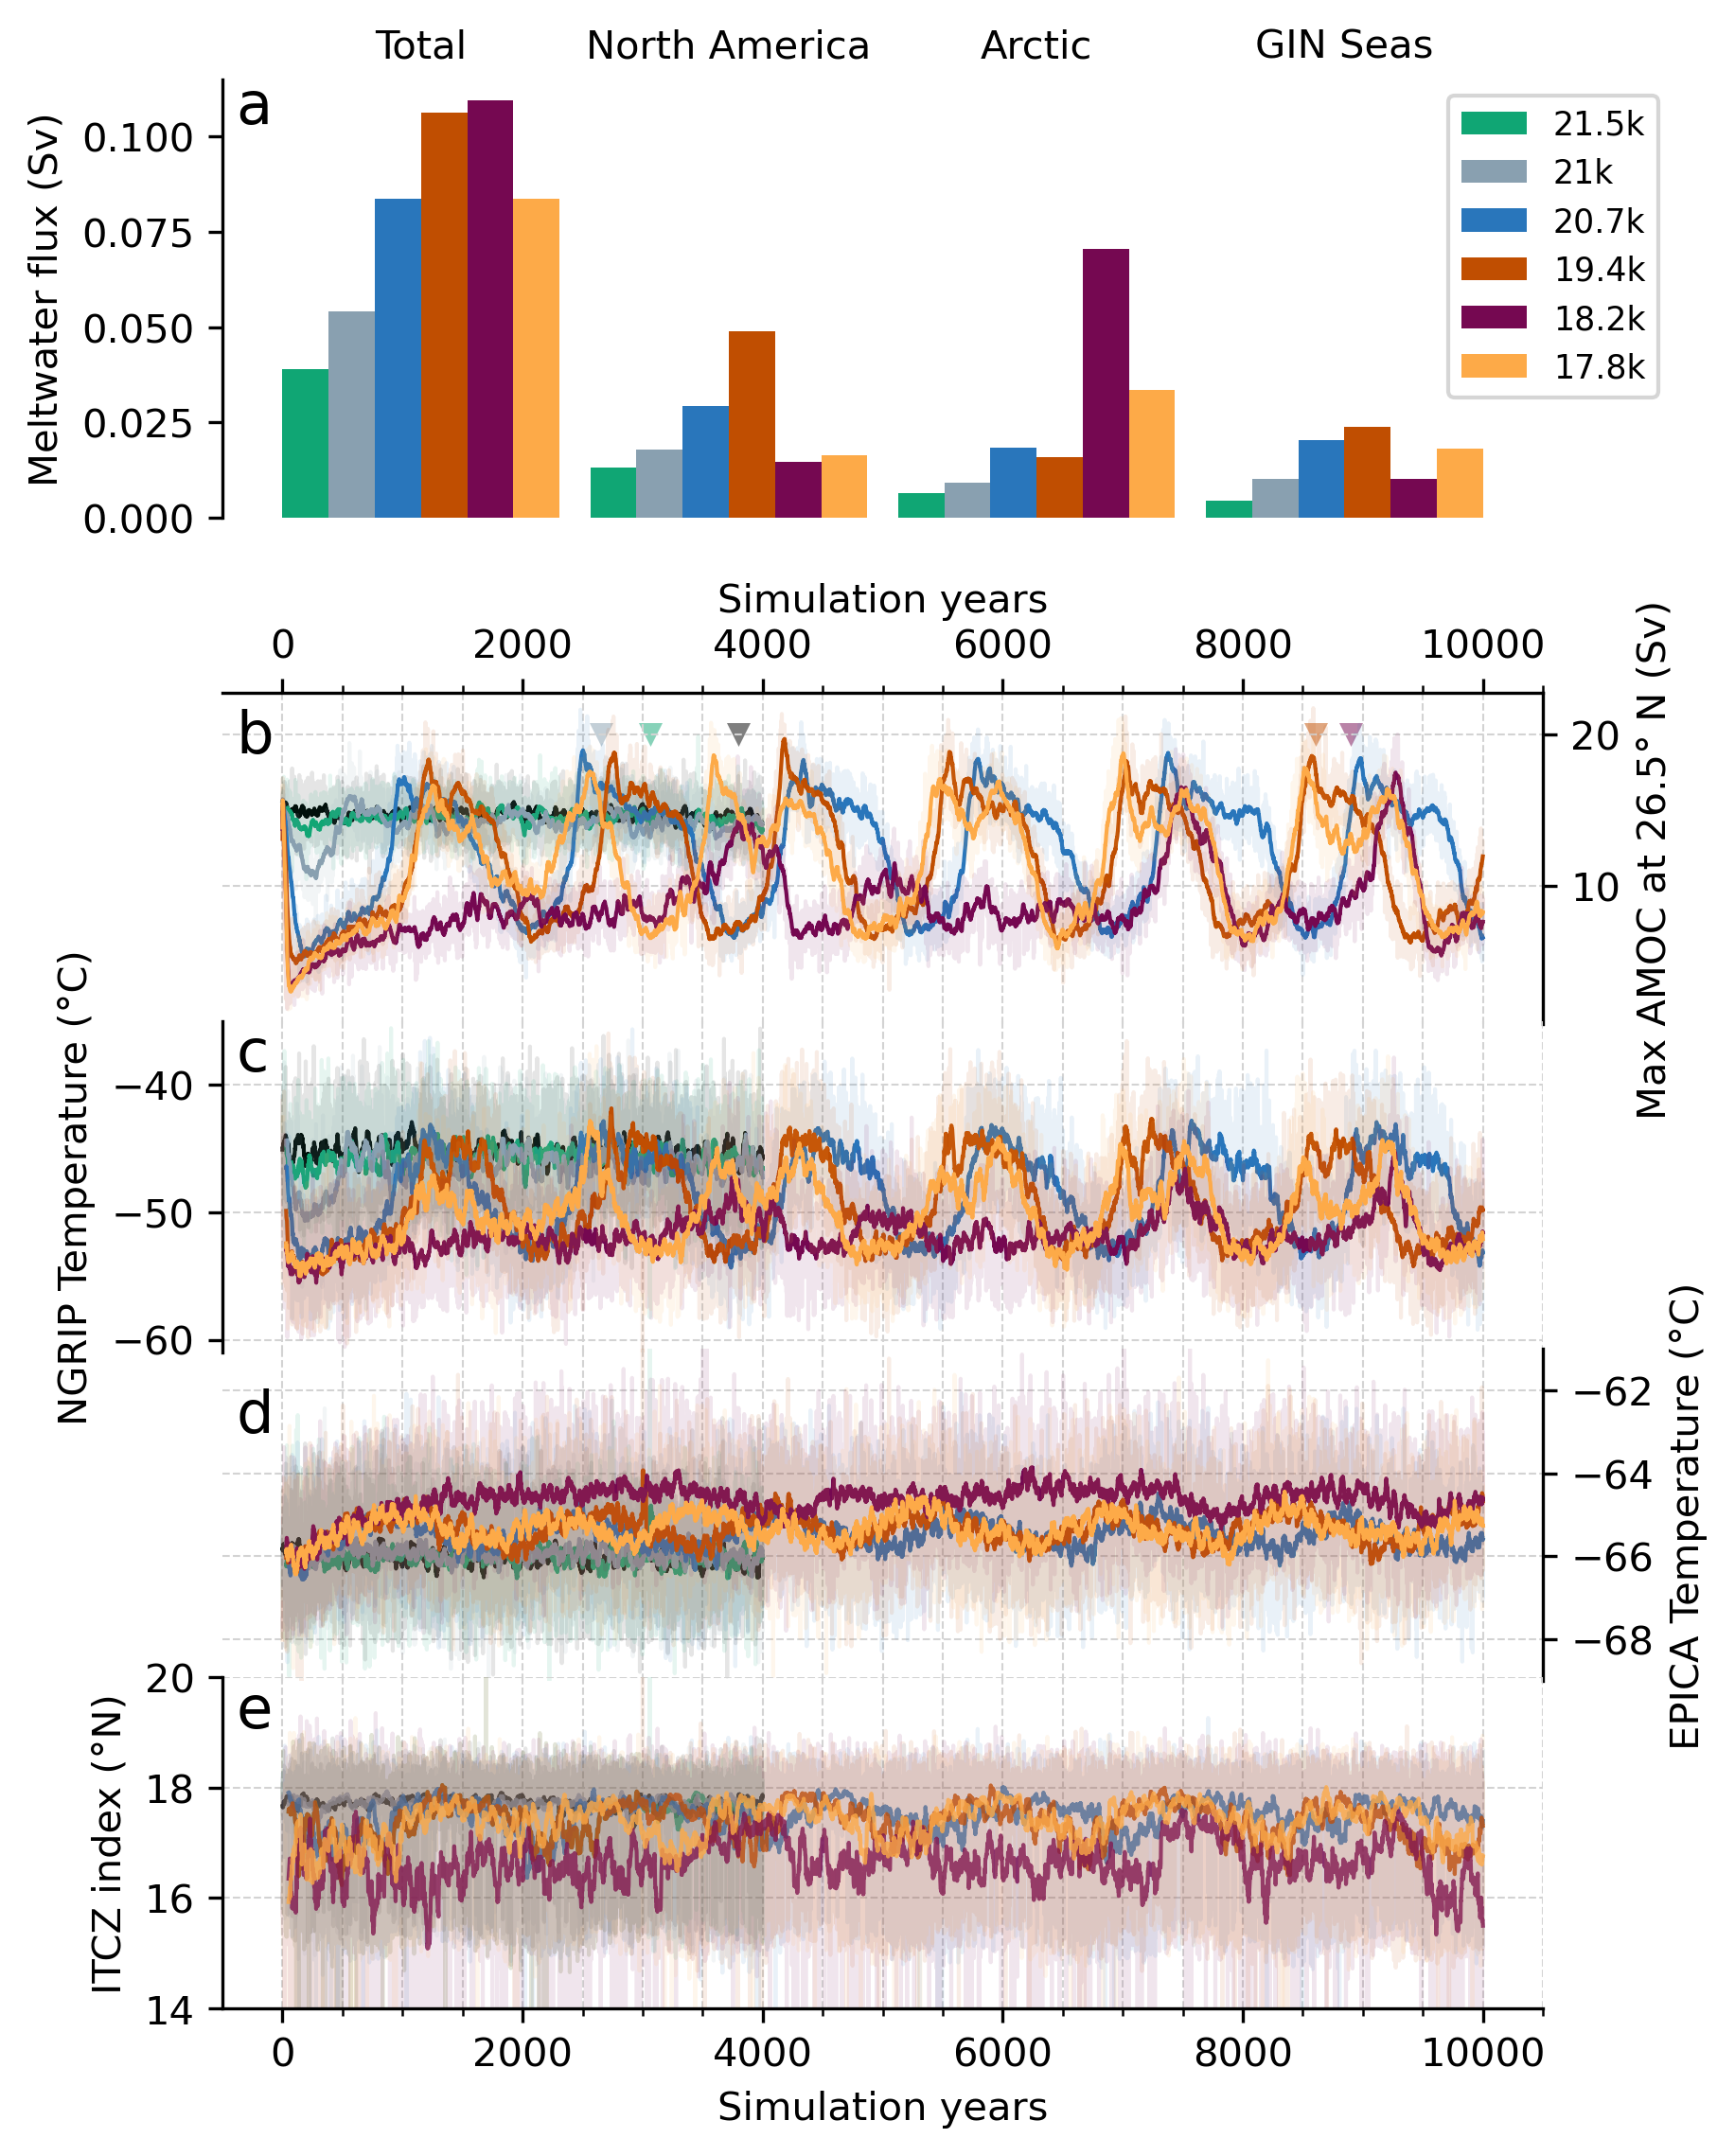

In [20]:
figMap = plt.figure(figsize=(6, 9), dpi=300)

gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 3], hspace=0.2)
axMw = figMap.add_subplot(gs[0],facecolor='None')
gsts = gridspec.GridSpecFromSubplotSpec(4, 1, hspace=-0.01, subplot_spec=gs[1])
axAMOC = figMap.add_subplot(gsts[0], facecolor='None')
axNGRIP = figMap.add_subplot(gsts[1], sharex=axAMOC,facecolor='None')
axEPICA = figMap.add_subplot(gsts[2], sharex=axAMOC,facecolor='None')
axITCZ = figMap.add_subplot(gsts[3], sharex=axAMOC,facecolor='None')

# MELTWATER

locations = ['Total', 'North America', 'Arctic', 'GIN Seas']
x = np.arange(len(locations))  # the label locations
width = 0.15  # the width of the bars

values = {}
for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    values[expt] = [total[expt], na[expt], arc[expt], gin[expt]]
    
axMw.bar(x - 5*width/2, values['xoupd'], width, label=labels['xoupd'], color=colors['xoupd'])
axMw.bar(x - 3*width/2, values['xouph'], width, label=labels['xouph'], color=colors['xouph'])
axMw.bar(x - width/2, values['tfgbi'], width, label=labels['tfgbi'], color=colors['tfgbi'])
axMw.bar(x + width/2, values['xoupl'], width, label=labels['xoupl'], color=colors['xoupl'])
axMw.bar(x + 3*width/2, values['xoupf'], width, label=labels['xoupf'], color=colors['xoupf'])
axMw.bar(x + 5*width/2, values['tfgbj'], width, label=labels['tfgbj'], color=colors['tfgbj'])

axMw.spines['right'].set_visible(False)
axMw.spines['bottom'].set_visible(False)
axMw.spines['top'].set_visible(False)
axMw.set_ylabel("Meltwater flux (Sv)")
axMw.set_xticks(x)
axMw.set_xticklabels(locations)
axMw.xaxis.set_ticks_position('top')
axMw.xaxis.set_label_position('top')
axMw.tick_params(axis='x', which='both',length=0)
axMw.legend(fontsize='small', bbox_to_anchor=(1.1, 1))
axMw.annotate('a', xy=(0.01,0.9), xycoords='axes fraction', size=15)

for expt in expts:
    
    start = 1000 if expt == 'xoupa' else 0
        
    axAMOC.plot(amoc[expt].processed_time(start_dates[expt])[start:], util.running_mean(amoc[expt].values()[start:], 30), color=colors[expt], linewidth=1, linestyle="-")
    axAMOC.plot(amoc[expt].processed_time(start_dates[expt])[start:], amoc[expt].values()[start:], color=colors[expt], linewidth=1, linestyle="-", alpha=0.1)
    if expt in smooth_date.keys():
        axAMOC.scatter(smooth_date[expt],  20, color=colors[expt], marker='v', linewidth=0, alpha=0.5)

    val = ngrip[expt].values()
    val[0] = np.nan
    axNGRIP.plot(ngrip[expt].processed_time(start_dates[expt])[start:], util.running_mean(val,30)[start:], color=colors[expt], linewidth=1, linestyle="-")
    axNGRIP.plot(ngrip[expt].processed_time(start_dates[expt])[start:], val[start:], color=colors[expt], linewidth=1, linestyle="-", alpha=0.1)

    val = epica[expt].values()
    val[0] = np.nan
    axEPICA.plot(epica[expt].processed_time(start_dates[expt])[start:], util.running_mean(val,30)[start:], color=colors[expt], linewidth=1, linestyle="-")
    axEPICA.plot(epica[expt].processed_time(start_dates[expt])[start:], val[start:], color=colors[expt], linewidth=1, linestyle="-", alpha=0.1)

    val = itcz_index[expt]
    val[0] = np.nan
    axITCZ.plot(precip[expt].processed_time(start_dates[expt])[start:], util.running_mean(val, 50)[start:], linewidth=1, color=colors[expt], linestyle="-", alpha=0.8)
    axITCZ.plot(precip[expt].processed_time(start_dates[expt])[start:], val[start:], color=colors[expt], linewidth=1, linestyle="-", alpha=0.1)

axAMOC.set_ylabel('Max AMOC at 26.5° N (Sv)')
axAMOC.spines['left'].set_visible(False)
axAMOC.spines['bottom'].set_visible(False)
axAMOC.yaxis.set_ticks_position('right')
axAMOC.yaxis.set_label_position('right')
axAMOC.xaxis.set_ticks_position('top')
axAMOC.set_xlabel("Simulation years")
axAMOC.xaxis.set_label_position('top')
axAMOC.xaxis.set_minor_locator(AutoMinorLocator())
axAMOC.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axAMOC.annotate('b', xy=(0.01,0.82), xycoords='axes fraction', size=15)

axNGRIP.spines['right'].set_visible(False)
axNGRIP.spines['top'].set_visible(False)
axNGRIP.spines['bottom'].set_visible(False)
axNGRIP.set_ylabel('NGRIP Temperature (°C)')
axNGRIP.set_ylim(-61, -35)
axNGRIP.tick_params(axis='x', colors='None', which='both')
axNGRIP.xaxis.set_minor_locator(AutoMinorLocator())
axNGRIP.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axNGRIP.annotate('c', xy=(0.01,0.85), xycoords='axes fraction', size=15)

axEPICA.spines['left'].set_visible(False)
axEPICA.spines['top'].set_visible(False)
axEPICA.spines['bottom'].set_visible(False)
axEPICA.tick_params(axis='x', colors='None', which="both")
axEPICA.xaxis.set_minor_locator(AutoMinorLocator())
axEPICA.yaxis.set_ticks_position('right')
axEPICA.yaxis.set_label_position('right')
axEPICA.set_ylabel('EPICA Temperature (°C)')
axEPICA.set_ylim(-69, -61)
axEPICA.xaxis.set_minor_locator(AutoMinorLocator())
axEPICA.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)
axEPICA.annotate('d', xy=(0.01,0.75), xycoords='axes fraction', size=15)

axITCZ.spines['right'].set_visible(False)
axITCZ.spines['top'].set_visible(False)
axITCZ.set_xlabel("Simulation years")
axITCZ.xaxis.set_minor_locator(AutoMinorLocator())
axITCZ.yaxis.set_ticks_position('left')
axITCZ.yaxis.set_label_position('left')
axITCZ.set_ylabel('ITCZ index (°N)')
axITCZ.set_ylim(14, 20)
axITCZ.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)
axITCZ.annotate('e', xy=(0.01,0.85), xycoords='axes fraction', size=15)

In [21]:
# figMap.savefig('Figures/amoc_ts.pdf', bbox_inches='tight', format='pdf')

### Figure 4 - Frequency analysis

In [22]:
ngrip = {}

for expt in ['tfgbi', 'xoupf', 'tfgbj', 'xouph']:
    ngrip[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
ngrip['tfgbr'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
ngrip['xoupd'] = hcm3.SATATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.SATATS('xoupd', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupf between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ N

In [23]:
filt, psd, fq, harm, fc, ngripf, ngripf_u = {}, {}, {}, {}, {}, {}, {}

filt_u = util.ButterLowPass(order=1, fc=2*10**-3, fs=1, mult=2)

for expt in ['tfgbi', 'tfgbr', 'xoupf', 'tfgbj', 'xoupd', 'xouph']:
    psd[expt], fq[expt] = util.psd(ngrip[expt].values(), fs=1, scale_by_freq=True)
    harm[expt] = np.where(fq[expt]<=10**-1)
    fc[expt] = util.fundamental_fq(psd[expt], fq[expt])
    filt[expt] = util.ButterLowPass(order=1, fc=fc[expt], fs=1, mult=3)
    
    ngripf[expt] = filt[expt].process(ngrip[expt].values())    
    ngripf_u[expt] = filt_u.process(ngrip[expt].values())

<ipython-input-24-3226ad07a776>:52: RuntimeWarning: divide by zero encountered in true_divide
  axSpectrum.secondary_xaxis('top', functions=(lambda a : 1/a, lambda a : 1/a)).set_xlabel('Periodicity (yrs)')


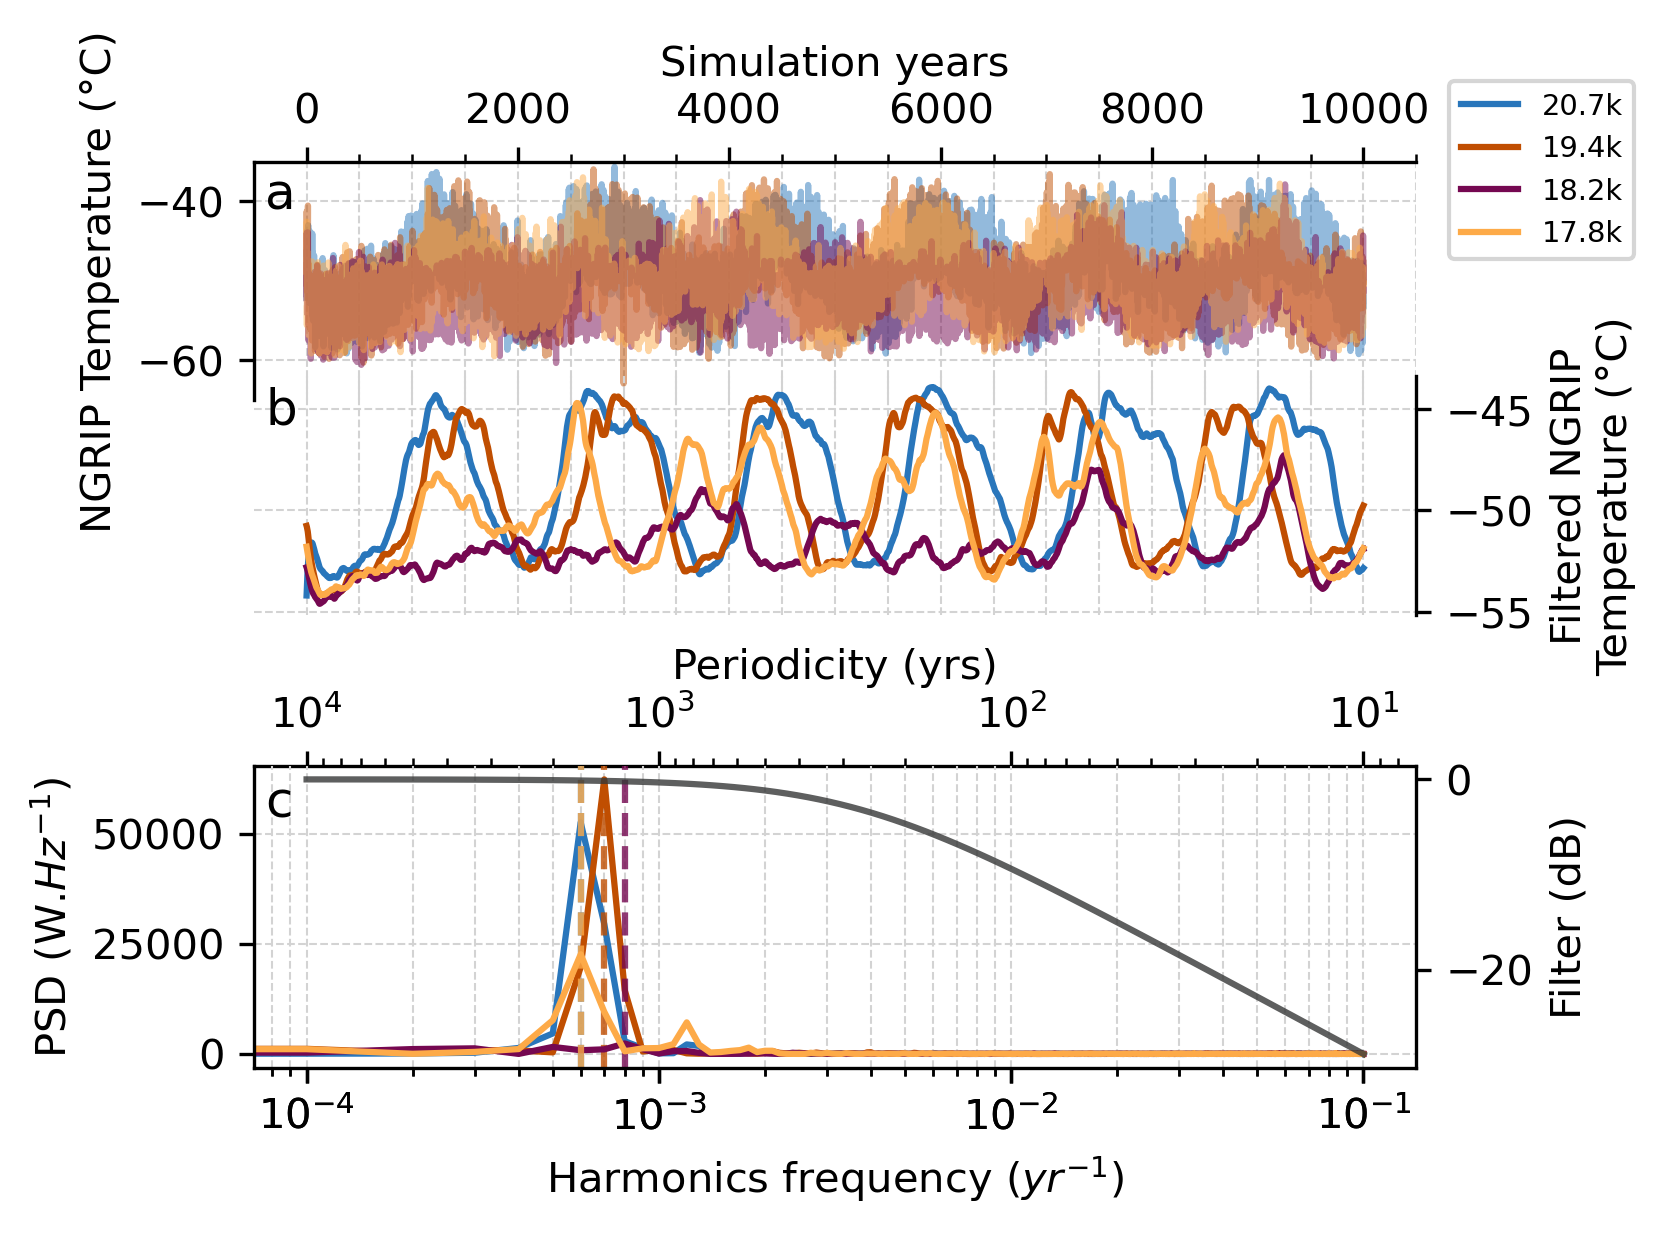

In [24]:
figMap = plt.figure(figsize=(5,4), dpi=300)

gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[3, 2], hspace=0.4)
gsts = gridspec.GridSpecFromSubplotSpec(2, 1, hspace=-0.1, subplot_spec=gs[0])
axData = figMap.add_subplot(gsts[0],facecolor='None')
axFilt = figMap.add_subplot(gsts[1],facecolor='None', sharex=axData)
axSpectrum = figMap.add_subplot(gs[1],facecolor='None')
axFilter = axSpectrum.twinx()

for expt in ['tfgbi', 'tfgbr', 'xoupf', 'tfgbj']:
    axData.plot(ngrip[expt].processed_time(start_dates[expt]), ngrip[expt].values(), color=colors[expt], alpha=0.5, linestyle="-")
    axFilt.plot(ngrip[expt].processed_time(start_dates[expt]), ngripf_u[expt], color=colors[expt], label=labels[expt])
    axSpectrum.semilogx(fq[expt][harm[expt]], psd[expt][harm[expt]], color=colors[expt])
    axSpectrum.axvline(fc[expt], linestyle='--', color=colors[expt], alpha=0.8)

filter_temp = filt[expt].plot(min_power=-4, max_power=-1, n_fq=100)
axFilter.semilogx(filter_temp[0], 20 * np.log10(abs(filter_temp[1])), color="xkcd:dark grey", alpha=0.8)
    
axData.spines['right'].set_visible(False)
axData.spines['bottom'].set_visible(False)
axData.set_ylabel('NGRIP Temperature (°C)')
axData.set_ylim(-65, -35)
axData.xaxis.set_ticks_position('top')
axData.set_xlabel("Simulation years")
axData.xaxis.set_label_position('top')
axData.xaxis.set_minor_locator(AutoMinorLocator())
axData.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axData.annotate('a', xy=(0.01,0.8), xycoords='axes fraction', size=12)

axFilt.spines['left'].set_visible(False)
axFilt.spines['top'].set_visible(False)
axFilt.spines['bottom'].set_visible(False)
axFilt.yaxis.set_ticks_position('right')
axFilt.yaxis.set_label_position('right')
axFilt.set_ylabel("Filtered NGRIP\nTemperature (°C)")
axFilt.xaxis.set_minor_locator(AutoMinorLocator())
axFilt.tick_params(axis='x', colors='None', which='both')
axFilt.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
lgd = axFilt.legend(fontsize='x-small', bbox_to_anchor=(1.2, 2.3))
axFilt.annotate('b', xy=(0.01,0.8), xycoords='axes fraction', size=12)

axSpectrum.spines['right'].set_visible(False)
axSpectrum.spines['top'].set_visible(False)
axSpectrum.yaxis.set_ticks_position('left')
axSpectrum.yaxis.set_label_position('left')
lbl = axSpectrum.set_ylabel(r"PSD (W.$Hz^{-1}$)")
axSpectrum.set_xlabel(r"Harmonics frequency ($yr^{-1}$)")
axSpectrum.xaxis.set_minor_locator(LogLocator(base=10,subs=[2,3,4,5,6,7,8,9]))
axSpectrum.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axSpectrum.annotate('c', xy=(0.01,0.83), xycoords='axes fraction', size=12)

axSpectrum.secondary_xaxis('top', functions=(lambda a : 1/a, lambda a : 1/a)).set_xlabel('Periodicity (yrs)')

axFilter.spines['left'].set_visible(False)
axFilter.spines['top'].set_visible(False)
axFilter.spines['bottom'].set_visible(False)
axFilter.yaxis.set_ticks_position('right')
axFilter.yaxis.set_label_position('right')
axFilter.set_ylabel("Filter (dB)")
axFilter.axes.xaxis.set_visible(True)

In [25]:
# figMap.savefig('Figures/fq_analysis.pdf', bbox_extra_artists=(lgd,lbl,), bbox_inches='tight', format='pdf')

In [26]:
print(f" 20.7k - Dominant fq : {fc['tfgbi']:.3e}, period {1/fc['tfgbi']:.3e}")
print(f" 19.4k - Dominant fq : {fc['tfgbr']:.3e}, period {1/fc['tfgbr']:.3e}")
print(f" 18.2k - Dominant fq : {fc['xoupf']:.3e}, period {1/fc['xoupf']:.3e}")
print(f" 17.8k - Dominant fq : {fc['tfgbj']:.3e}, period {1/fc['tfgbj']:.3e}")

 20.7k - Dominant fq : 5.999e-04, period 1.667e+03
 19.4k - Dominant fq : 6.999e-04, period 1.429e+03
 18.2k - Dominant fq : 7.999e-04, period 1.250e+03
 17.8k - Dominant fq : 6.001e-04, period 1.666e+03


### Figure 5 - Zonal Means

In [27]:
lon_at_min, lon_at_max, lat_at_min, lat_at_max = 290, 370, -20, 80
zone_at = util.cycle_box(lon_at_min, lon_at_max, lat_at_min, lat_at_max)
box_at = zones.Box(lon_at_min, lon_at_max, lat_at_min, lat_at_max, z_min = -1000)
plane_at = zones.Box(lon_at_min, lon_at_max, lat_at_min, lat_at_max)

clim = {'xoupd':14, 'xouph':12, 'tfgbi':8, 'tfgbj':8, 'xoupl':8, 'xoupf':8}
wlim = {'xoupd':14.5, 'xouph':14.5, 'tfgbi':15, 'tfgbj':15, 'xoupl':16, 'xoupf':13.5}

In [28]:
amocv, amocts, amocv, amocts_mode, idxes = {}, {}, {}, {}, {}
amoc, sat, sst, mld, wice, sice = {}, {}, {}, {}, {}, {}
amoc_mode, sat_mode, sst_mode, mld_mode, wice_mode, sice_mode = {}, {}, {}, {}, {}, {}

amoc_ref = hcm3.MERIDATS('xoupa', chunks=10).atlantic(mode_z="max", mode_t='mean', zone=zones.Box(lat_min=-20, lat_max=80)).values()
sat_ref = hcm3.SATATS('xoupa', chunks=10).sat(mode_lon="mean", mode_t='mean', zone=plane_at).values()
sst_ref = hcm3.SSTATS('xoupa', chunks=10).sst(mode_lon="mean", mode_t='mean', zone=plane_at).values()
mld_ref = hcm3.MLDATS('xoupa', chunks=10).mld(mode_lon="mean", mode_t='mean', zone=plane_at).values()
wice_ref = hcm3.WICEATS('xoupa', chunks=10).ice_conc(mode_lon="mean", mode_t='mean', zone=plane_at).values()*100
sice_ref = hcm3.SICEATS('xoupa', chunks=10).ice_conc(mode_lon="mean", mode_t='mean', zone=plane_at).values()*100

for mode in ['Cold', 'Warm']:
    amoc_mode[mode], sat_mode[mode], sst_mode[mode], mld_mode[mode], wice_mode[mode], sice_mode[mode] = {}, {}, {}, {}, {}, {}
    idxes[mode] = {}
    amocts_mode[mode] = {}
    
for expt in ['tfgbi', 'xoupl', 'tfgbj', 'xouph', 'xoupf']:
    
    # Calculate AMOC Index Time series
    
    if expt == 'xoupl':
        amocts[expt] = hcm3.MERIDATS('tfgbr', end_year=3999, chunks=10).concat(
            hcm3.MERIDATS('xoupl', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
    elif expt == 'xoupd':
        amocts[expt] = hcm3.MERIDATS('tfgbd', end_year=4060, chunks=10).concat(
            hcm3.MERIDATS('xoupd', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
    else:
        amocts[expt] = hcm3.MERIDATS(expt, chunks=10).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
    amocv[expt] = util.running_mean(amocts[expt].values(), 30)
    amocts_mode['Cold'][expt] = np.where(amocv[expt]<=clim[expt], amocv[expt], np.nan)
    amocts_mode['Warm'][expt] = np.where(amocv[expt]>=wlim[expt], amocv[expt], np.nan)
    idxes['Cold'][expt] = np.where(amocv[expt]<=clim[expt])
    idxes['Warm'][expt] = np.where(amocv[expt]>=wlim[expt])
    
    
    # Calculate AMOC zonal mean
    
    if expt == 'xoupl':
        amoc[expt] = hcm3.MERIDATS('tfgbr', end_year=3999, chunks=10).concat(
            hcm3.MERIDATS('xoupl', chunks=10)).atlantic(mode_z="max", zone=zones.Box(lat_min=-20, lat_max=80))
    else:
        amoc[expt]=hcm3.MERIDATS(expt, chunks=10).atlantic(mode_z="max", zone=zones.Box(lat_min=-20, lat_max=80))    
    amoc_mode['Cold'][expt] = np.nanmean(amoc[expt].values()[idxes['Cold'][expt]], axis=0)
    amoc_mode['Warm'][expt] = np.nanmean(amoc[expt].values()[idxes['Warm'][expt]], axis=0)

    # Calculate SAT zonal mean
    
    if expt == 'xoupl':
        sat[expt] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lon="mean", zone=plane_at)
    else:
        sat[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lon="mean", zone=plane_at)
    sat_mode['Cold'][expt] = np.nanmean(sat[expt].values()[idxes['Cold'][expt]], axis=0)
    sat_mode['Warm'][expt] = np.nanmean(sat[expt].values()[idxes['Warm'][expt]], axis=0)

    # Calculate SST zonal mean

    if expt == 'xoupl':
        sst[expt] = hcm3.SSTATS('tfgbr', end_year=3999, chunks=10).concat(
            hcm3.SSTATS('xoupl', chunks=10)).sst(mode_lon="mean", zone=plane_at)
    else:
        sst[expt] = hcm3.SSTATS(expt, chunks=10).sst(mode_lon="mean", zone=plane_at)
    sst_mode['Cold'][expt] = np.nanmean(sst[expt].values()[idxes['Cold'][expt]], axis=0)
    sst_mode['Warm'][expt] = np.nanmean(sst[expt].values()[idxes['Warm'][expt]], axis=0)

    # Calculate MLD zonal mean
    
    if expt == 'xoupl':
        mld[expt] = hcm3.MLDATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.MLDATS('xoupl', chunks=10)).mld(mode_lon="mean", zone=plane_at)
    else:
        mld[expt] = hcm3.MLDATS(expt, chunks=10).mld(mode_lon="mean", zone=plane_at)
    mld_mode['Cold'][expt] = np.nanmean(mld[expt].values()[idxes['Cold'][expt]], axis=0)
    mld_mode['Warm'][expt] = np.nanmean(mld[expt].values()[idxes['Warm'][expt]], axis=0)

    # Calculate Winter sea ice zonal mean
    
    if expt == 'xoupl':
        wice[expt] = hcm3.WICEATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.WICEATS('xoupl', chunks=10)).ice_conc(mode_lon="mean", zone=plane_at)
    else:
        wice[expt] = hcm3.WICEATS(expt, chunks=10).ice_conc(mode_lon="mean", zone=plane_at)
    wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
    wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100

    # Calculate Summer sea ice zonal mean
    
    if expt == 'xoupl':
        sice[expt] = hcm3.SICEATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SICEATS('xoupl', chunks=10)).ice_conc(mode_lon="mean", zone=plane_at)
    else:
        sice[expt] = hcm3.SICEATS(expt, chunks=10).ice_conc(mode_lon="mean", zone=plane_at)
    sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
    sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupa between years 1 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Processing z: max
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: mean
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SSTATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SST.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: mean

<ipython-input-28-6e28c9401117>:80: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-28-6e28c9401117>:81: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : tfgbi between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-28-6e28c9401117>:89: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-28-6e28c9401117>:90: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbr between years 1001 and 3999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupl between years 4001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbr between years 1001 and 3999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupl between years 4001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlanti

<ipython-input-28-6e28c9401117>:80: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-28-6e28c9401117>:81: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : tfgbr between years 1001 and 3999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : xoupl between years 4001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-28-6e28c9401117>:89: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-28-6e28c9401117>:90: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instan

<ipython-input-28-6e28c9401117>:80: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-28-6e28c9401117>:81: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-28-6e28c9401117>:89: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-28-6e28c9401117>:90: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xouph between years 1001 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xouph between years 1001 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xouph between years 1000 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.

<ipython-input-28-6e28c9401117>:80: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-28-6e28c9401117>:81: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : xouph between years 1001 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-28-6e28c9401117>:89: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-28-6e28c9401117>:90: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupf between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupf between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupf between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instan

<ipython-input-28-6e28c9401117>:80: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-28-6e28c9401117>:81: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : xoupf between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-28-6e28c9401117>:89: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-28-6e28c9401117>:90: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


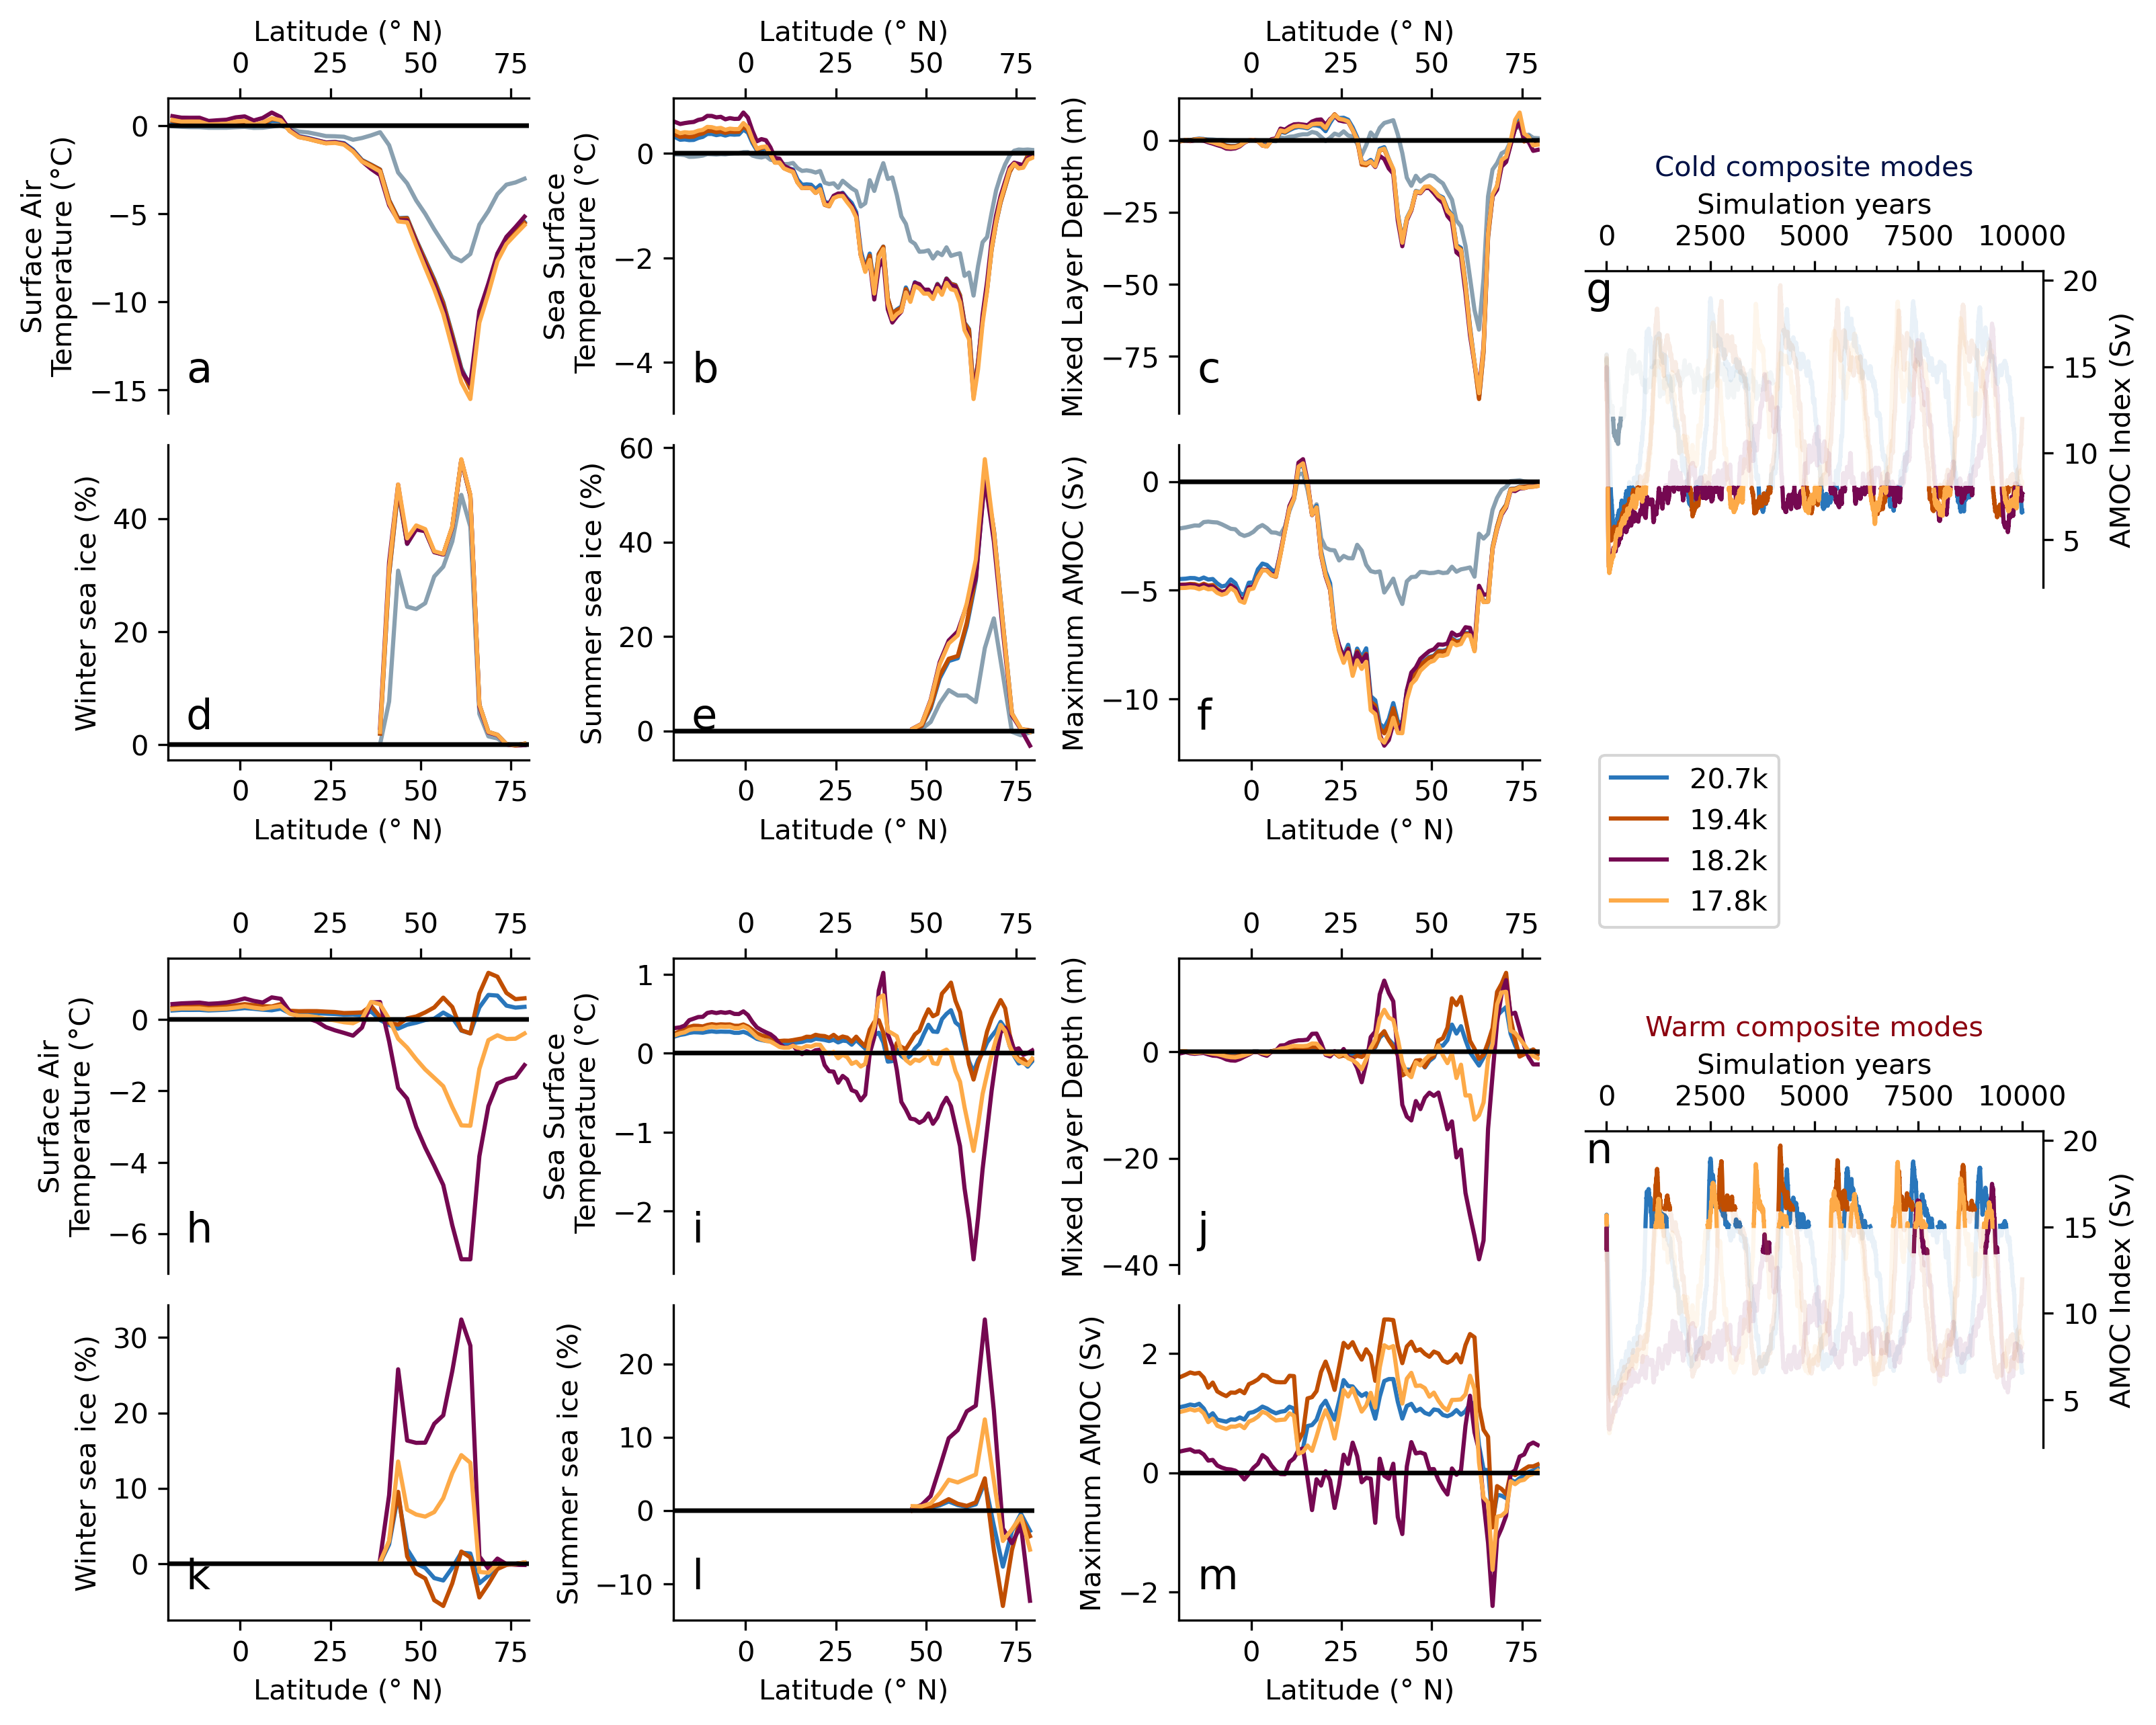

In [29]:
figMap = plt.figure(figsize=(12,10), dpi=300)

ax= {}
grid = figMap.add_gridspec(2, 1, hspace=0.3)
color_mode = {'Warm':'xkcd:crimson', 'Cold':'xkcd:navy blue'}

gridCold = grid[0].subgridspec(4, 2, width_ratios=[9,3], wspace=0.05)
ax['Cold'] = {}
gridColdPlots = gridCold[:,0].subgridspec(2, 3, wspace=0.4, hspace=0.1)
((ax['Cold']['SAT'], ax['Cold']['SST'], ax['Cold']['MLD']), 
 (ax['Cold']['WICE'], ax['Cold']['SICE'], ax['Cold']['AMOC'])) = gridColdPlots.subplots()
ax['Cold']['TS'] = figMap.add_subplot(gridCold[1:3,1])

gridWarm = grid[1].subgridspec(4, 2, width_ratios=[9,3], wspace=0.05)
ax['Warm'] = {}
gridWarmPlots = gridWarm[:,0].subgridspec(2, 3, wspace=0.4, hspace=0.1)
((ax['Warm']['SAT'], ax['Warm']['SST'], ax['Warm']['MLD']), 
 (ax['Warm']['WICE'], ax['Warm']['SICE'], ax['Warm']['AMOC'])) = gridWarmPlots.subplots()
ax['Warm']['TS'] = figMap.add_subplot(gridWarm[1:3,1])

letter = 'a'

expts = {'Cold':['xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj'],
         'Warm':['tfgbi', 'xoupl', 'xoupf', 'tfgbj']}

for mode in ['Cold', 'Warm']:

    for expt in expts[mode]:
        ax[mode]['SAT'].plot(sat[expt].latb, sat_mode[mode][expt] - sat_ref, color=colors[expt])
        ax[mode]['SST'].plot(sst[expt].lat, sst_mode[mode][expt] - sst_ref, color=colors[expt])
        ax[mode]['MLD'].plot(mld[expt].lat, mld_mode[mode][expt] - mld_ref, color=colors[expt])
        ax[mode]['WICE'].plot(wice[expt].latb, wice_mode[mode][expt] - wice_ref, color=colors[expt])
        ax[mode]['SICE'].plot(sice[expt].latb, sice_mode[mode][expt] - sice_ref, color=colors[expt])
        ax[mode]['AMOC'].plot(amoc[expt].latb, amoc_mode[mode][expt] - amoc_ref, color=colors[expt])

        for variable in ['SAT', 'SST', 'MLD', 'WICE', 'SICE', 'AMOC']:
            ax[mode][variable].axhline(y=0, color='k')
            ax[mode][variable].spines['right'].set_visible(False)
            ax[mode][variable].set_xlim([-20,80])
            
        for variable in ['SAT', 'SST', 'MLD']:
            ax[mode][variable].spines['bottom'].set_visible(False)
            ax[mode][variable].xaxis.set_ticks_position('top')
            ax[mode][variable].xaxis.set_label_position('top')
            
        for variable in ['WICE', 'SICE', 'AMOC']:
            ax[mode][variable].spines['top'].set_visible(False)
            ax[mode][variable].xaxis.set_ticks_position('bottom')
            ax[mode][variable].xaxis.set_label_position('bottom')
            
            
    ax[mode]['SAT'].set_ylabel("Surface Air\nTemperature (°C)", fontsize='medium')
    ax[mode]['SST'].set_ylabel("Sea Surface\n Temperature (°C)", fontsize='medium')
    ax[mode]['MLD'].set_ylabel("Mixed Layer Depth (m)")
    ax[mode]['WICE'].set_ylabel("Winter sea ice (%)")
    ax[mode]['SICE'].set_ylabel("Summer sea ice (%)")
    ax[mode]['AMOC'].set_ylabel("Maximum AMOC (Sv)")

    for variable in ['SAT', 'SST', 'MLD', 'WICE', 'SICE', 'AMOC']:
        ax[mode][variable].annotate(letter, xy=(0.05,0.1), xycoords='axes fraction', size=15)
        letter = chr(ord(letter)+1)

    
    for expt in expts[mode]:
        ax[mode]['TS'].plot(amocts[expt].processed_time(start_dates[expt]), 
                            amocv[expt], color=colors[expt], linestyle="-", alpha=0.1)
        ax[mode]['TS'].plot(amocts[expt].processed_time(start_dates[expt]), 
                            amocts_mode[mode][expt], color=colors[expt], linestyle="-", label=labels[expt])
    ax[mode]['TS'].spines['left'].set_visible(False)
    ax[mode]['TS'].spines['bottom'].set_visible(False)
    ax[mode]['TS'].yaxis.set_ticks_position('right')
    ax[mode]['TS'].yaxis.set_label_position('right')
    ax[mode]['TS'].set_ylabel('AMOC Index (Sv)')
    ax[mode]['TS'].xaxis.set_ticks_position('top')
    ax[mode]['TS'].set_xlabel("Simulation years")
    ax[mode]['TS'].xaxis.set_label_position('top')
    ax[mode]['TS'].xaxis.set_minor_locator(AutoMinorLocator())
    
    ax[mode]['TS'].set_title(f"{mode} composite modes", fontsize='medium', color=color_mode[mode])
    
    ax[mode]['TS'].annotate(letter, xy=(0,0.9), xycoords='axes fraction', size=15)
    letter = chr(ord(letter)+1)
    
ax['Warm']['TS'].legend(fontsize='medium', loc='lower left', bbox_to_anchor=(0, 1.6, 1,1))

for variable in ['SAT', 'SST', 'MLD', 'WICE', 'SICE', 'AMOC']:
    ax['Cold'][variable].set_xlabel("Latitude (° N)")

for variable in ['WICE', 'SICE', 'AMOC']:
    ax['Warm'][variable].set_xlabel("Latitude (° N)")

In [30]:
# figMap.savefig('Figures/zonal.pdf', bbox_inches='tight', format='pdf')

## Discussion

### Figure 6 - Convection mode identification

In [31]:
amoc, ngrip, mld, spg = {}, {}, {}, {}
mld_index = {}
lon_mld_com, lat_mld_com, mag_mld_com = {}, {}, {}
lon_mld_hs, lat_mld_hs, mag_mld_hs = {}, {}, {}
spg_index = {}
lon_spg_com, lat_spg_com, mag_spg_com = {}, {}, {}
lon_spg_hs, lat_spg_hs, mag_spg_hs = {}, {}, {}

for expt in ['tfgbi', 'tfgbj', 'tfgbr']:
    print(f"Processing {expt}")
    
    if expt == 'tfgbr':
        amoc[expt] = hcm3.MERIDATS(expt, end_year=3999, chunks=10).concat(
            hcm3.MERIDATS('xoupl', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
        ngrip[expt] = hcm3.SATATS(expt, end_year=3999, chunks=10).concat(
            hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
    else:
        amoc[expt] = hcm3.MERIDATS(expt, chunks=10).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
        ngrip[expt] = hcm3.SATATS(expt, chunks=10).sat(
            mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)

    if expt == 'tfgbr':
        ts = hcm3.MLDATS(expt, end_year=3999, chunks=10).concat(hcm3.MLDATS('xoupl', chunks=10))
    else:
        ts = hcm3.MLDATS(expt, chunks=10)
    
    lon_mld_com[expt], lat_mld_com[expt], mag_mld_com[expt] = map(
        np.array, zip(*util.get_com(ts.mld(zone=plane_na).values(), ts.mld(zone=plane_na).lon_p,
                                    ts.mld(zone=plane_na).lat_p)))
    lon_mld_hs[expt], lat_mld_hs[expt], mag_mld_hs[expt] = map(
        np.array, zip(*util.get_hs(ts.mld(zone=plane_na).values(), ts.mld(zone=plane_na).lon_p,
                                   ts.mld(zone=plane_na).lat_p)))
    mld[expt] = ts.mld(mode_lon="mean", mode_lat="mean", zone=plane_na)
    mld_index[expt] = ts.mld(mode_lon="max", mode_lat="max", zone=plane_na)

    if expt == 'tfgbr':
        ts = hcm3.OCNSTREAMATS(expt, end_year=3999, chunks=10).concat(hcm3.OCNSTREAMATS('xoupl', chunks=10))
    else:
        ts = hcm3.OCNSTREAMATS(expt, chunks=10)
    lon_spg_com[expt], lat_spg_com[expt], mag_spg_com[expt] = map(
        np.array, zip(*util.get_com(-ts.stream(zone=plane_na).values(), ts.stream(zone=plane_na).lon_p,
                                    ts.stream(zone=plane_na).lat_p)))
    lon_spg_hs[expt], lat_spg_hs[expt], mag_spg_hs[expt] = map(
        np.array, zip(*util.get_hs(-ts.stream(zone=plane_na).values(), ts.stream(zone=plane_na).lon_p, 
                                   ts.stream(zone=plane_na).lat_p)))
    spg[expt] = ts.stream(mode_lon="mean", mode_lat="mean", zone=plane_na)
    spg_index[expt] = -ts.stream(mode_lon='weighted_mean', mode_lat='weighted_mean', zone=plane_esp).values()

Processing tfgbi
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbi between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MLDATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing MLD.
____ Coordinates imported in the GeoDataA

__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array
__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array
__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array
__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array
__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array
__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: mean
____ Processing latitude: mean
____ Rebuilding the data_array
__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: max
____ Processing latitude: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.OCNSTREAMATS'> : tfgbr between years 1000 and 3999.
____ Import succeeded.
____ 

In [32]:
amoc['xoupa'] = hcm3.MERIDATS('xoupa', chunks=10).atlantic(
    mode_t='mean', mode_lat="value", value_lat=26.5, mode_z="max")
ngrip['xoupa'] = hcm3.SATATS('xoupa', chunks=10).sat(
    mode_t='mean', mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)

ts = hcm3.MLDATS('xoupa', chunks=10)
lon_mld_com['xoupa'], lat_mld_com['xoupa'] = util.get_com(
    ts.mld(mode_t='mean', zone=plane_na).values(), ts.mld(mode_t='mean',zone=plane_na).lon_p, 
    ts.mld(mode_t='mean',zone=plane_na).lat_p)
mld['xoupa'] = ts.mld(mode_t='mean',mode_lon="mean", mode_lat="mean", zone=plane_na)
mld_index['xoupa'] = ts.mld(mode_t='mean',mode_lon="max", mode_lat="max", zone=plane_na)

ts = hcm3.OCNSTREAMATS('xoupa', chunks=10)
lon_spg_com['xoupa'], lat_spg_com['xoupa'] = util.get_com(
    -ts.stream(mode_t='mean',zone=plane_na).values(), ts.stream(mode_t='mean', zone=plane_na).lon_p,
    ts.stream(mode_t='mean',zone=plane_na).lat_p)
spg['xoupa'] = ts.stream(mode_t='mean',mode_lon="mean", mode_lat="mean", zone=plane_na)
spg_index['xoupa'] = -ts.stream(mode_t='mean',mode_lon='weighted_mean', mode_lat='weighted_mean',
                                zone=plane_esp).values()

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupa between years 1 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MLDATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing MLD.
____ Coordinates impor

In [33]:
filt, psd, fq, harm, fc, ngripf = {}, {}, {}, {}, {}, {}

ngripf, amocf, spgf_index, mldf_index = {}, {}, {}, {}
lon_mldf_com, lat_mldf_com = {}, {}
lon_spgf_com, lat_spgf_com = {}, {}

for expt in ['tfgbi', 'tfgbr', 'tfgbj']:
    psd[expt], fq[expt] = util.psd(ngrip[expt].values(), fs=1, scale_by_freq=True)
    harm[expt] = np.where(fq[expt]<=10**-1)
    fc[expt] = util.fundamental_fq(psd[expt], fq[expt])
    filt[expt] = util.ButterLowPass(order=1, fc=2*10**-3, fs=1, mult=2)
    
    ngripf[expt] = filt[expt].process(ngrip[expt].values())  

    amocf[expt] = filt[expt].process(amoc[expt].values())
    mldf_index[expt] = filt[expt].process(mld_index[expt].values())
    lon_mldf_com[expt] = filt[expt].process(lon_mld_com[expt])
    lat_mldf_com[expt] = filt[expt].process(lat_mld_com[expt])
    spgf_index[expt] = filt[expt].process(spg_index[expt])
    lon_spgf_com[expt] = filt[expt].process(lon_spg_com[expt])
    lat_spgf_com[expt] = filt[expt].process(lat_spg_com[expt])

In [34]:
lon_nshs_min, lon_nshs_max, lat_nshs_min, lat_nshs_max = 335.5, 337.5, 59, 60
zone_nshs = util.cycle_box(lon_nshs_min, lon_nshs_max, lat_nshs_min, lat_nshs_max)

lon_ibhs_min, lon_ibhs_max, lat_ibhs_min, lat_ibhs_max = 332, 334, 58, 59
zone_ibhs = util.cycle_box(lon_ibhs_min, lon_ibhs_max, lat_ibhs_min, lat_ibhs_max)

lon_offhs_min, lon_offhs_max, lat_offhs_min, lat_offhs_max = 328, 330, 59, 60
zone_offhs = util.cycle_box(lon_offhs_min, lon_offhs_max, lat_offhs_min, lat_offhs_max)

ds_lsm = xr.open_dataset('/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.omask.nc')
lon_lsm, lat_lsm = util.cycle_lon(ds_lsm.longitude.values), ds_lsm.latitude.values
lon_lsm[-1]=359
lsm = util.cycle_lon(ds_lsm.lsm.values)

Text(0.97, 1.05, 'k')

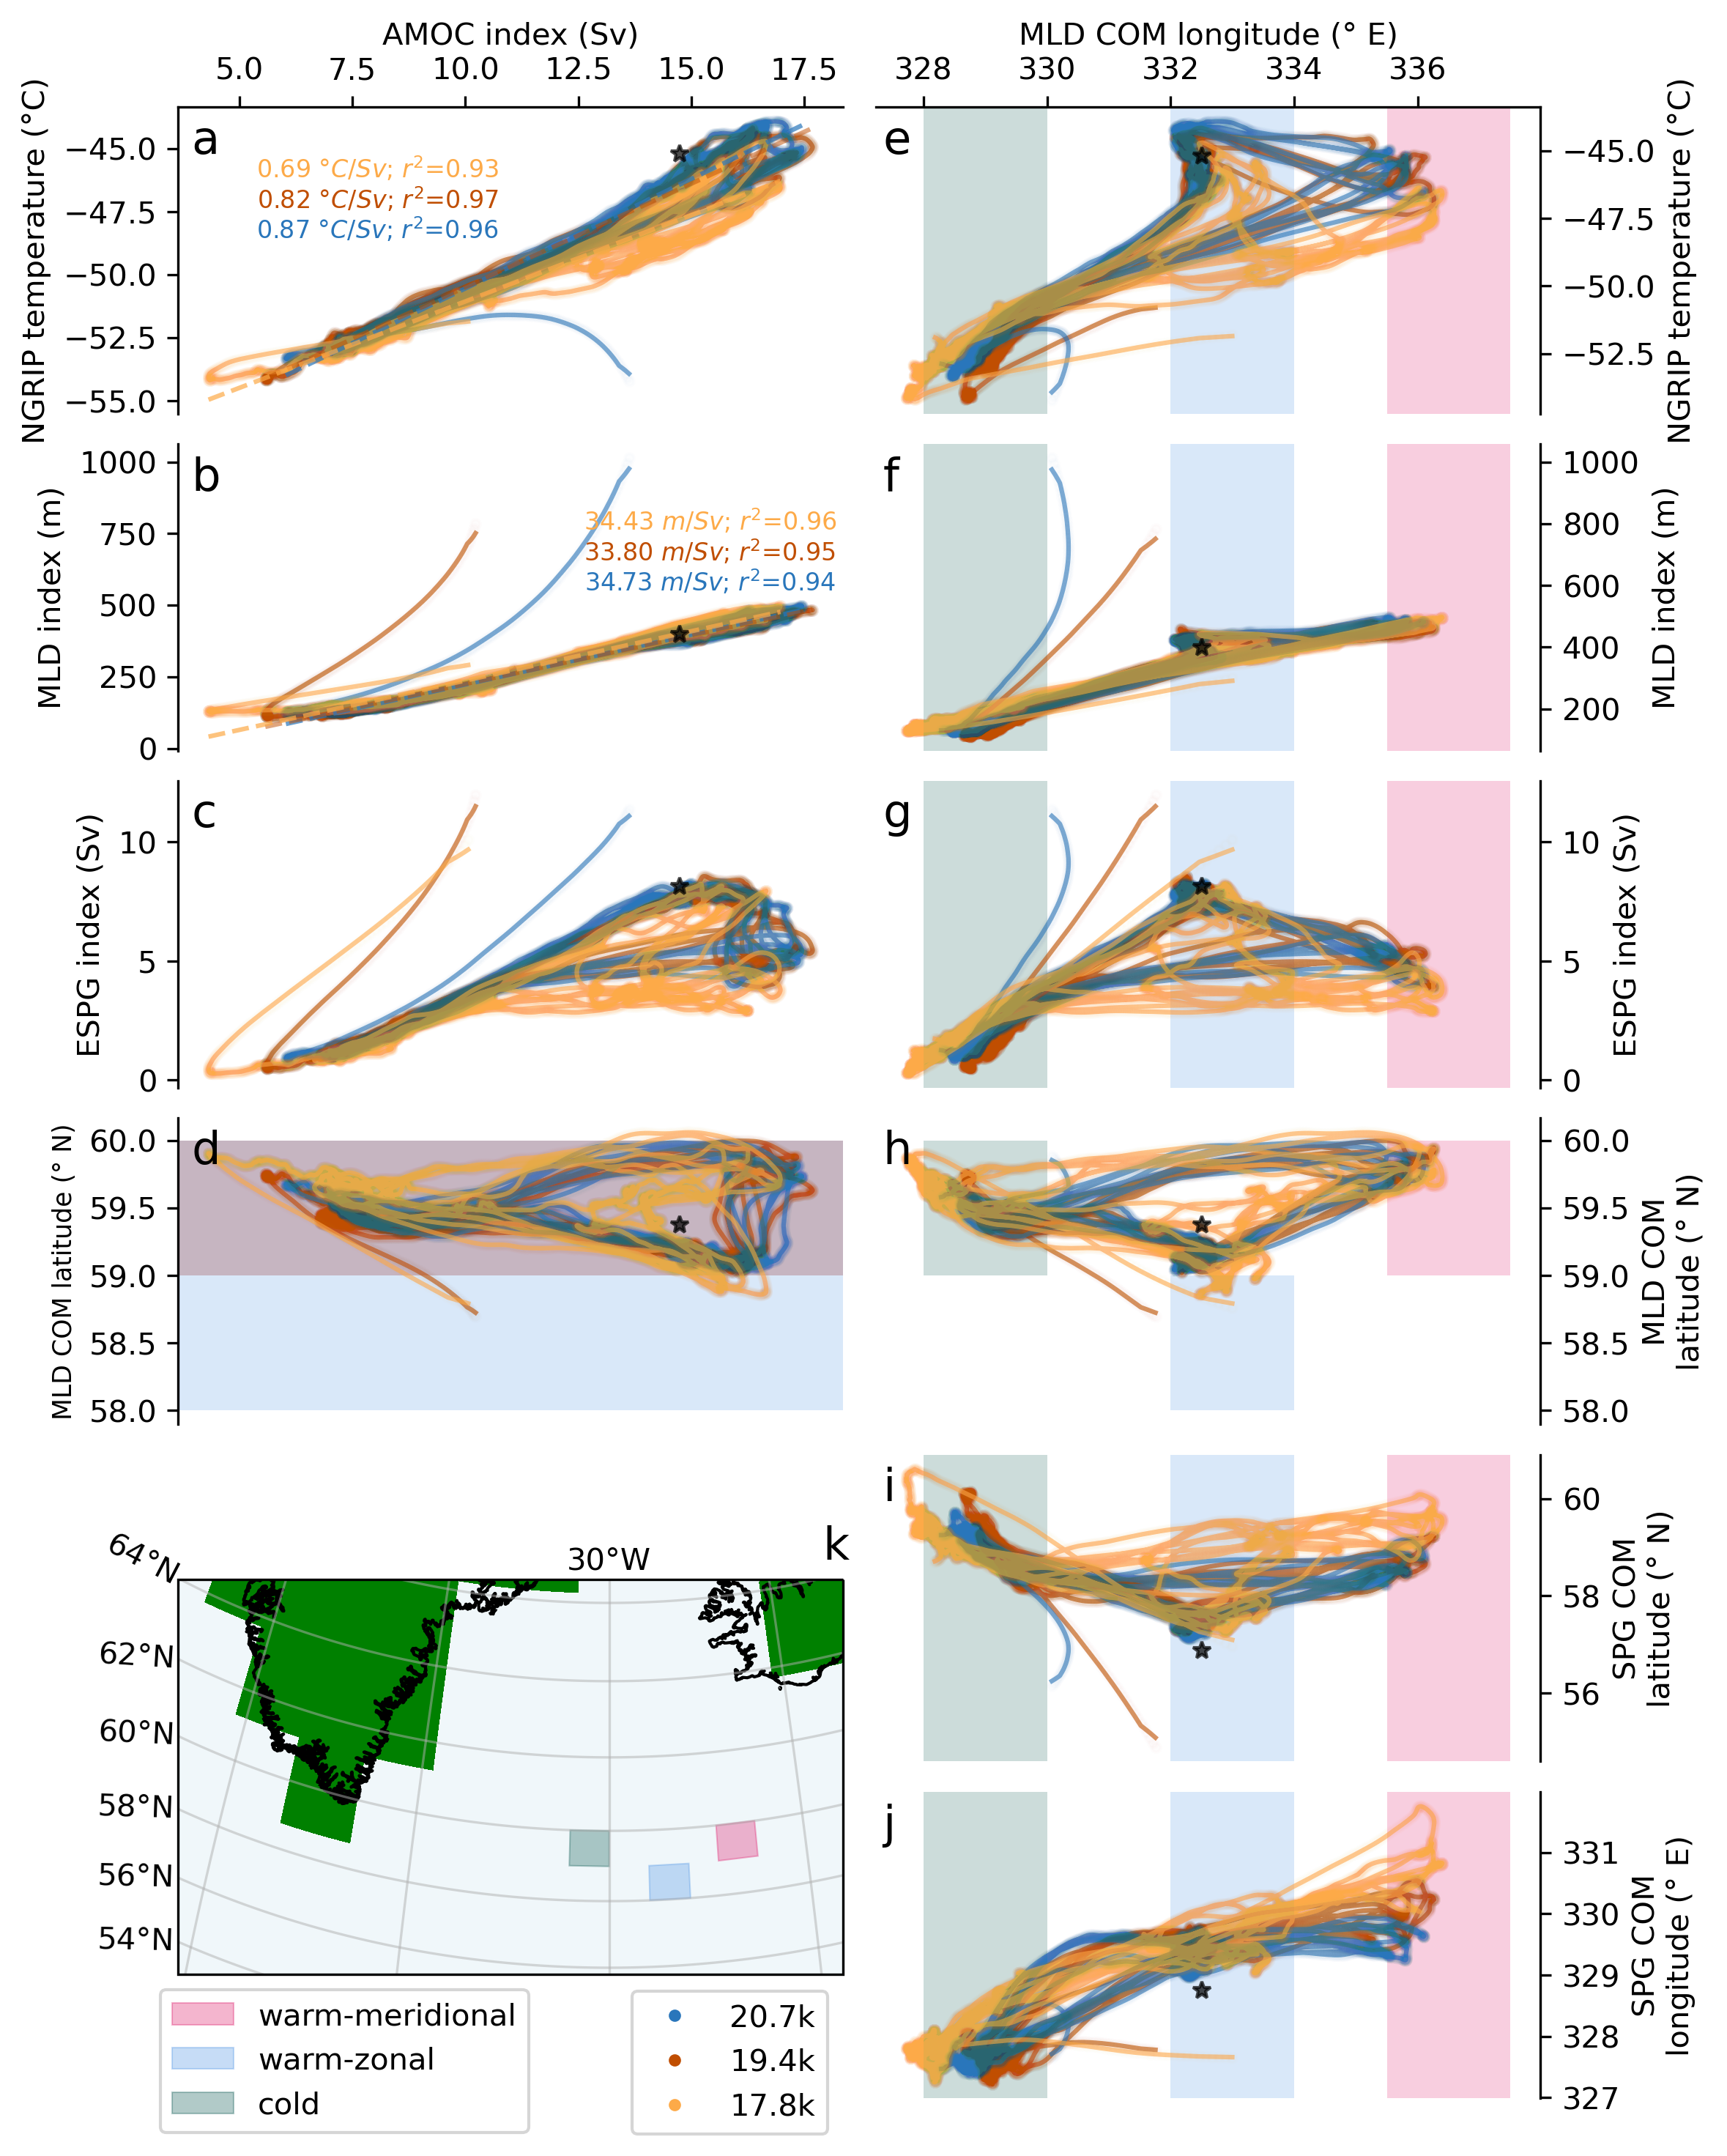

In [35]:
projection_map = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=70, satellite_height=3000000)
alpha_line = 0.6
alpha_marker=0.01
marker = '.'
figMap = plt.figure(figsize=(8,12), dpi=300)

colors_mode = {'meridional':'xkcd:cerise', 'zonal':'xkcd:dark sky blue', 'cold':'xkcd:dark blue green'}

grid = figMap.add_gridspec(6, 2, wspace=0.05, hspace=0.1)
axAMOCNGRIP = figMap.add_subplot(grid[0,0])
axAMOCMLD = figMap.add_subplot(grid[1,0])
axAMOCESPG= figMap.add_subplot(grid[2,0])
axAMOCMLDlat = figMap.add_subplot(grid[3,0])
axMap = figMap.add_subplot(grid[4:,0], projection=projection_map)
axMLDNGRIP = figMap.add_subplot(grid[0,1])
axMLDMLD = figMap.add_subplot(grid[1,1])
axMLDESPG = figMap.add_subplot(grid[2,1])
axMLDMLDlat = figMap.add_subplot(grid[3,1])
axMLDSPGlat = figMap.add_subplot(grid[4,1])
axMLDSPGlon = figMap.add_subplot(grid[5,1])

lreg_ngrip, lreg_mld = {}, {}
amoc_axis = {}

for expt in ['tfgbr', 'tfgbi', 'tfgbj']:

    n = min(len(ngripf[expt]), len(amocf[expt]))
    axAMOCNGRIP.plot(amocf[expt][:n], util.rmean(ngripf[expt][:n], 10), color=colors[expt], alpha=alpha_line)
    axAMOCNGRIP.plot(amocf[expt][:n], ngripf[expt][:n], marker, color=colors[expt], alpha=alpha_marker)
    lreg_ngrip[expt] = stats.linregress(amocf[expt][:n], ngripf[expt][:n])
    amoc_axis[expt] = np.linspace(np.min(amocf[expt][:n]), np.max(amocf[expt][:n]))

    n = min(len(mldf_index[expt]), len(amocf[expt]))
    axAMOCMLD.plot(amocf[expt][:n], util.rmean(mldf_index[expt][:n], 10), color=colors[expt], alpha=alpha_line)
    axAMOCMLD.plot(amocf[expt][:n], mldf_index[expt][:n], marker, color=colors[expt], alpha=alpha_marker)
    lreg_mld[expt] = stats.linregress(amocf[expt][:n], mldf_index[expt][:n])

    n = min(len(spgf_index[expt]), len(amocf[expt]))
    axAMOCESPG.plot(amocf[expt][:n], util.rmean(spgf_index[expt][:n], 10), color=colors[expt], alpha=alpha_line)
    axAMOCESPG.plot(amocf[expt][:n], spgf_index[expt][:n], marker, color=colors[expt], alpha=alpha_marker)

    n = min(len(lat_mldf_com[expt]), len(amocf[expt]))
    axAMOCMLDlat.plot(amocf[expt][:n], util.rmean(lat_mldf_com[expt][:n], 10), color=colors[expt], alpha=alpha_line)
    axAMOCMLDlat.plot(amocf[expt][:n], lat_mldf_com[expt][:n], marker, color=colors[expt], alpha=alpha_marker)
    
    n = min(len(lon_mldf_com[expt]), len(amocf[expt]))
    axMLDNGRIP.plot(lon_mldf_com[expt][:n], util.rmean(ngripf[expt][:n], 10), color=colors[expt], alpha=alpha_line)
    axMLDNGRIP.plot(lon_mldf_com[expt][:n], ngripf[expt][:n], marker, color=colors[expt], alpha=alpha_marker)

    n = min(len(mldf_index[expt]), len(lon_mldf_com[expt]))
    axMLDMLD.plot(lon_mldf_com[expt][:n], util.rmean(mldf_index[expt][:n], 10), color=colors[expt], alpha=alpha_line)
    axMLDMLD.plot(lon_mldf_com[expt][:n], mldf_index[expt][:n], marker, color=colors[expt], alpha=alpha_marker)

    n = min(len(spgf_index[expt]), len(lon_mldf_com[expt]))
    axMLDESPG.plot(lon_mldf_com[expt][:n], util.rmean(spgf_index[expt][:n], 10), color=colors[expt], alpha=alpha_line)
    axMLDESPG.plot(lon_mldf_com[expt][:n], spgf_index[expt][:n], marker, color=colors[expt], alpha=alpha_marker)

    n = min(len(lat_mldf_com[expt]), len(lon_mldf_com[expt]))
    axMLDMLDlat.plot(lon_mldf_com[expt][:n], util.rmean(lat_mldf_com[expt][:n], 10), color=colors[expt], alpha=alpha_line)
    axMLDMLDlat.plot(lon_mldf_com[expt][:n], lat_mldf_com[expt][:n], marker, color=colors[expt], alpha=alpha_marker)

    n = min(len(lat_spgf_com[expt]), len(lon_mldf_com[expt]))
    axMLDSPGlat.plot(lon_mldf_com[expt][:n], util.rmean(lat_spgf_com[expt][:n], 10), color=colors[expt], alpha=alpha_line)
    axMLDSPGlat.plot(lon_mldf_com[expt][:n], lat_spgf_com[expt][:n], marker, color=colors[expt], alpha=alpha_marker)

    n = min(len(lon_spgf_com[expt]), len(lon_mldf_com[expt]))
    axMLDSPGlon.plot(lon_mldf_com[expt][:n], util.rmean(lon_spgf_com[expt][:n], 10), color=colors[expt], alpha=alpha_line)
    axMLDSPGlon.plot(lon_mldf_com[expt][:n], lon_spgf_com[expt][:n], marker, color=colors[expt], alpha=alpha_marker)

axAMOCNGRIP.plot(amoc_axis['tfgbi'], [lreg_ngrip['tfgbi'][0]*i + lreg_ngrip['tfgbi'][1] for i in amoc_axis['tfgbi']],
                 alpha=0.7, color=colors['tfgbi'], linestyle="--")
axAMOCNGRIP.annotate(fr"{lreg_ngrip['tfgbi'][0]:.2f} $°C/Sv$; $r^2$={lreg_ngrip['tfgbi'][2]**2:.2f}",
             xy=(0.3, 0.6), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8,
                     color=colors['tfgbi'])

axAMOCNGRIP.plot(amoc_axis['tfgbr'], [lreg_ngrip['tfgbr'][0]*i + lreg_ngrip['tfgbr'][1] for i in amoc_axis['tfgbr']],
                 alpha=0.5, color=colors['tfgbr'], linestyle="--")
axAMOCNGRIP.annotate(fr"{lreg_ngrip['tfgbr'][0]:.2f} $°C/Sv$; $r^2$={lreg_ngrip['tfgbr'][2]**2:.2f}",
             xy=(0.3, 0.7), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8,
                     color=colors['tfgbr'])

axAMOCNGRIP.plot(amoc_axis['tfgbj'], [lreg_ngrip['tfgbj'][0]*i + lreg_ngrip['tfgbj'][1] for i in amoc_axis['tfgbj']],
                 alpha=0.7, color=colors['tfgbj'], linestyle="--")
axAMOCNGRIP.annotate(fr"{lreg_ngrip['tfgbj'][0]:.2f} $°C/Sv$; $r^2$={lreg_ngrip['tfgbj'][2]**2:.2f}",
             xy=(0.3, 0.8), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, 
                     color=colors['tfgbj'])

axAMOCNGRIP.set_xlabel("AMOC index (Sv)")
axAMOCNGRIP.set_ylabel("NGRIP temperature (°C)")
axAMOCNGRIP.spines['right'].set_visible(False)
axAMOCNGRIP.spines['bottom'].set_visible(False)
axAMOCNGRIP.xaxis.set_ticks_position('top')
axAMOCNGRIP.xaxis.set_label_position('top')
axAMOCNGRIP.annotate('a', xy=(0.02,0.85), xycoords='axes fraction', size=15)


axAMOCMLD.plot(amoc_axis['tfgbi'], [lreg_mld['tfgbi'][0]*i + lreg_mld['tfgbi'][1] for i in amoc_axis['tfgbi']],
               alpha=0.7, color=colors['tfgbi'], linestyle="--")
axAMOCMLD.annotate(fr"{lreg_mld['tfgbi'][0]:.2f} $m/Sv$; $r^2$={lreg_mld['tfgbi'][2]**2:.2f}",
                   xy=(0.8, 0.55), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, 
                   color=colors['tfgbi'])

axAMOCMLD.plot(amoc_axis['tfgbr'], [lreg_mld['tfgbr'][0]*i + lreg_mld['tfgbr'][1] for i in amoc_axis['tfgbr']],
               alpha=0.5, color=colors['tfgbr'], linestyle="--")
axAMOCMLD.annotate(fr"{lreg_mld['tfgbr'][0]:.2f} $m/Sv$; $r^2$={lreg_mld['tfgbr'][2]**2:.2f}",
                   xy=(0.8, 0.65), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, 
                   color=colors['tfgbr'])

axAMOCMLD.plot(amoc_axis['tfgbj'], [lreg_mld['tfgbj'][0]*i + lreg_mld['tfgbj'][1] for i in amoc_axis['tfgbj']],
               alpha=0.7, color=colors['tfgbj'], linestyle="--")
axAMOCMLD.annotate(fr"{lreg_mld['tfgbj'][0]:.2f} $m/Sv$; $r^2$={lreg_mld['tfgbj'][2]**2:.2f}",
                   xy=(0.8, 0.75), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, 
                   color=colors['tfgbj'])

axAMOCMLD.set_ylabel("MLD index (m)")
axAMOCMLD.xaxis.set_visible(False)
axAMOCMLD.spines['right'].set_visible(False)
axAMOCMLD.spines['top'].set_visible(False)
axAMOCMLD.spines['bottom'].set_visible(False)
axAMOCMLD.annotate('b', xy=(0.02,0.85), xycoords='axes fraction', size=15)

axAMOCESPG.set_ylabel("ESPG index (Sv)")
axAMOCESPG.xaxis.set_visible(False)
axAMOCESPG.spines['right'].set_visible(False)
axAMOCESPG.spines['top'].set_visible(False)
axAMOCESPG.spines['bottom'].set_visible(False)
axAMOCESPG.annotate('c', xy=(0.02,0.85), xycoords='axes fraction', size=15)

axAMOCMLDlat.axhspan(lat_nshs_min, lat_nshs_max, color=colors_mode['meridional'], linewidth=0, alpha=0.2)
axAMOCMLDlat.axhspan(lat_ibhs_min, lat_ibhs_max, color=colors_mode['zonal'], linewidth=0, alpha=0.2)
axAMOCMLDlat.axhspan(lat_offhs_min, lat_offhs_max, color=colors_mode['cold'], linewidth=0, alpha=0.2)
axAMOCMLDlat.set_ylabel("MLD COM latitude (° N)", fontsize='small')
axAMOCMLDlat.xaxis.set_visible(False)
axAMOCMLDlat.spines['right'].set_visible(False)
axAMOCMLDlat.spines['top'].set_visible(False)
axAMOCMLDlat.spines['bottom'].set_visible(False)
axAMOCMLDlat.annotate('d', xy=(0.02,0.85), xycoords='axes fraction', size=15)


axMLDNGRIP.axvspan(lon_nshs_min, lon_nshs_max, color=colors_mode['meridional'], linewidth=0, alpha=0.2)
axMLDNGRIP.axvspan(lon_ibhs_min, lon_ibhs_max, color=colors_mode['zonal'], linewidth=0, alpha=0.2)
axMLDNGRIP.axvspan(lon_offhs_min, lon_offhs_max, color=colors_mode['cold'], linewidth=0, alpha=0.2)
axMLDNGRIP.xaxis.set_ticks_position('top')
axMLDNGRIP.xaxis.set_label_position('top')
axMLDNGRIP.set_xlabel("MLD COM longitude (° E)")
axMLDNGRIP.yaxis.set_ticks_position('right')
axMLDNGRIP.yaxis.set_label_position('right')
axMLDNGRIP.set_ylabel("NGRIP temperature (°C)")
axMLDNGRIP.spines['left'].set_visible(False)
axMLDNGRIP.spines['bottom'].set_visible(False)
axMLDNGRIP.annotate('e', xy=(0.01,0.85), xycoords='axes fraction', size=15)

axMLDMLD.axvspan(lon_nshs_min, lon_nshs_max, color=colors_mode['meridional'], linewidth=0, alpha=0.2)
axMLDMLD.axvspan(lon_ibhs_min, lon_ibhs_max, color=colors_mode['zonal'], linewidth=0, alpha=0.2)
axMLDMLD.axvspan(lon_offhs_min, lon_offhs_max, color=colors_mode['cold'], linewidth=0, alpha=0.2)
axMLDMLD.yaxis.set_ticks_position('right')
axMLDMLD.yaxis.set_label_position('right')
axMLDMLD.set_ylabel("MLD index (m)")
axMLDMLD.spines['left'].set_visible(False)
axMLDMLD.spines['bottom'].set_visible(False)
axMLDMLD.spines['top'].set_visible(False)
axMLDMLD.xaxis.set_visible(False)
axMLDMLD.annotate('f', xy=(0.01,0.85), xycoords='axes fraction', size=15)

axMLDESPG.axvspan(lon_nshs_min, lon_nshs_max, color=colors_mode['meridional'], linewidth=0, alpha=0.2)
axMLDESPG.axvspan(lon_ibhs_min, lon_ibhs_max, color=colors_mode['zonal'], linewidth=0, alpha=0.2)
axMLDESPG.axvspan(lon_offhs_min, lon_offhs_max, color=colors_mode['cold'], linewidth=0, alpha=0.2)
axMLDESPG.yaxis.set_ticks_position('right')
axMLDESPG.yaxis.set_label_position('right')
axMLDESPG.set_ylabel("ESPG index (Sv)")
axMLDESPG.spines['left'].set_visible(False)
axMLDESPG.spines['bottom'].set_visible(False)
axMLDESPG.spines['top'].set_visible(False)
axMLDESPG.xaxis.set_visible(False)
axMLDESPG.annotate('g', xy=(0.01,0.85), xycoords='axes fraction', size=15)

axMLDMLDlat.fill(zone_nshs[0], zone_nshs[1], color=colors_mode['meridional'], linewidth=0, alpha=0.2, fill=True)
axMLDMLDlat.fill(zone_ibhs[0],zone_ibhs[1], color=colors_mode['zonal'], linewidth=0, alpha=0.2, fill=True)
axMLDMLDlat.fill(zone_offhs[0], zone_offhs[1], color=colors_mode['cold'], linewidth=0, alpha=0.2, fill=True)
axMLDMLDlat.yaxis.set_ticks_position('right')
axMLDMLDlat.yaxis.set_label_position('right')
axMLDMLDlat.set_ylabel("MLD COM\nlatitude (° N)")
axMLDMLDlat.xaxis.set_visible(False)
axMLDMLDlat.spines['left'].set_visible(False)
axMLDMLDlat.spines['bottom'].set_visible(False)
axMLDMLDlat.spines['top'].set_visible(False)
axMLDMLDlat.annotate('h', xy=(0.01,0.85), xycoords='axes fraction', size=15)

axMLDSPGlat.axvspan(lon_nshs_min, lon_nshs_max, color=colors_mode['meridional'], linewidth=0, alpha=0.2)
axMLDSPGlat.axvspan(lon_ibhs_min, lon_ibhs_max, color=colors_mode['zonal'], linewidth=0, alpha=0.2)
axMLDSPGlat.axvspan(lon_offhs_min, lon_offhs_max, color=colors_mode['cold'], linewidth=0, alpha=0.2)
axMLDSPGlat.yaxis.set_ticks_position('right')
axMLDSPGlat.yaxis.set_label_position('right')
axMLDSPGlat.set_ylabel("SPG COM\nlatitude (° N)")
axMLDSPGlat.xaxis.set_visible(False)
axMLDSPGlat.spines['left'].set_visible(False)
axMLDSPGlat.spines['bottom'].set_visible(False)
axMLDSPGlat.spines['top'].set_visible(False)
axMLDSPGlat.annotate('i', xy=(0.01,0.85), xycoords='axes fraction', size=15)

axMLDSPGlon.axvspan(lon_nshs_min, lon_nshs_max, color=colors_mode['meridional'], linewidth=0, alpha=0.2)
axMLDSPGlon.axvspan(lon_ibhs_min, lon_ibhs_max, color=colors_mode['zonal'], linewidth=0, alpha=0.2)
axMLDSPGlon.axvspan(lon_offhs_min, lon_offhs_max, color=colors_mode['cold'], linewidth=0, alpha=0.2)
axMLDSPGlon.yaxis.set_ticks_position('right')
axMLDSPGlon.yaxis.set_label_position('right')
axMLDSPGlon.set_ylabel("SPG COM\nlongitude (° E)")
axMLDSPGlon.xaxis.set_visible(False)
axMLDSPGlon.spines['left'].set_visible(False)
axMLDSPGlon.spines['bottom'].set_visible(False)
axMLDSPGlon.spines['top'].set_visible(False)
axMLDSPGlon.annotate('j', xy=(0.01,0.85), xycoords='axes fraction', size=15)
[axMLDSPGlon.plot([], [], marker, color=colors[expt], label=labels[expt]) for expt in ['tfgbi', 'tfgbr', 'tfgbj']]
axMLDSPGlon.legend(bbox_to_anchor=(-0.05, 0.4))

axAMOCNGRIP.plot(amoc['xoupa'].values(), ngrip['xoupa'].values(), '*', color=colors['xoupa'], alpha=0.7)
axAMOCMLD.plot(amoc['xoupa'].values(), mld_index['xoupa'].values(), '*', color=colors['xoupa'], alpha=0.7)
axAMOCESPG.plot(amoc['xoupa'].values(), spg_index['xoupa'], '*', color=colors['xoupa'], alpha=0.7)
axAMOCMLDlat.plot(amoc['xoupa'].values(), lat_mld_com['xoupa'], '*', color=colors['xoupa'], alpha=0.7)
axMLDNGRIP.plot(lon_mld_com['xoupa'], ngrip['xoupa'].values(), '*', color=colors['xoupa'], alpha=0.7)
axMLDMLD.plot(lon_mld_com['xoupa'], mld_index['xoupa'].values(), '*', color=colors['xoupa'], alpha=0.7)
axMLDESPG.plot(lon_mld_com['xoupa'], spg_index['xoupa'], '*', color=colors['xoupa'], alpha=0.7)
axMLDSPGlon.plot(lon_mld_com['xoupa'], lon_spg_com['xoupa'], '*', color=colors['xoupa'], alpha=0.7)
axMLDSPGlat.plot(lon_mld_com['xoupa'], lat_spg_com['xoupa'], '*', color=colors['xoupa'], alpha=0.7)
axMLDMLDlat.plot(lon_mld_com['xoupa'], lat_mld_com['xoupa'], '*', color=colors['xoupa'], alpha=0.7)

axMap.fill(zone_nshs[0], zone_nshs[1], color=colors_mode['meridional'], linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree(), fill=True, label='warm-meridional')
axMap.fill(zone_ibhs[0], zone_ibhs[1], color=colors_mode['zonal'], linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree(), fill=True, label='warm-zonal')
axMap.fill(zone_offhs[0], zone_offhs[1], color=colors_mode['cold'], linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree(), fill=True, label='cold')
axMap.pcolormesh(lon_lsm, lat_lsm, lsm, transform=ccrs.PlateCarree(), cmap=util.trunc_cmap(plt.get_cmap('ocean_r'), 0.02, 1))
axMap.coastlines()
gl = axMap.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle='-')
gl.bottom_labels = False
gl.right_labels = False
lon_formatter = LongitudeFormatter(degree_symbol='° ')
lat_formatter = LatitudeFormatter(degree_symbol='° ')
axMap.xaxis.set_major_formatter(lon_formatter)
axMap.yaxis.set_major_formatter(lat_formatter)
axMap.xaxis.set_ticks_position('top')
axMap.xaxis.set_label_position('top')
axMap.yaxis.set_ticks_position('left')
axMap.yaxis.set_label_position('left')
axMap.legend(bbox_to_anchor=(0.55, 0))
axMap.set_extent([309,341,55,65])
axMap.annotate('k', xy=(0.97,1.05), xycoords='axes fraction', size=15)

In [36]:
#figMap.savefig('Figures/dragon.pdf', bbox_inches='tight', format='pdf')

### Figure 7 - Modes summaries

In [37]:
ngrip = hcm3.SATATS('tfgbj', chunks=10).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
ngripv = ngrip.values()

filt_u = util.ButterLowPass(order=1, fc=2*10**-3, fs=1, mult=2)
ngripf = filt_u.process(ngripv)

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array


In [38]:
zone = {}
mld_gin, mld_irm, mldf_gin, mldf_irm = {}, {}, {}, {}

zone['gin'] = zones.Box(345, 375, 63, 73, z_min = -1000)
zone['ls'] = zones.Box(295, 315, 50, 65, z_min = -1000)
zone['irm'] = zones.Box(320, 338, 55, 67, z_min = -1000)
zone['esa'] = zones.Box(320, 375, 55, 73, z_min = -1000)

regions = ['gin', 'irm', 'esa', 'ls']

for expt in ['tfgbj']:
    mld_gin[expt] = hcm3.MLDATS(expt, chunks=10).mld(zone=zone['gin'], mode_lon='mean', mode_lat='mean')
    mldf_gin[expt] = filt_u.process(mld_gin[expt].values())
    mld_irm[expt] = hcm3.MLDATS(expt, chunks=10).mld(zone=zone['irm'], mode_lon='mean', mode_lat='mean')
    mldf_irm[expt] = filt_u.process(mld_irm[expt].values())

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MLDATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: mean
____ Processing latitude: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MLDATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: mean
____ Processing latitude: mean
____ Rebuilding the data_array


In [39]:
# TFGBI
span = {'meridional':[2250, 4600, 6500, 8000, 9500],
        'zonal':[3550, 5300, 6950, 8500, 10200],
        'cold':[1250, 4100, 5800, 7500, 9000]}

In [40]:
mld_mode, wice_mode = {}, {}
idxes = {}
zone_na = zones.Box(lat_min=0)

expt = 'tfgbj'

for mode in ['meridional', 'zonal', 'cold']:
    idxes[mode] = np.array([np.arange(t_span-50-1000, t_span+50-1000) for t_span in span[mode]]).flatten()
    ts_mld = hcm3.WMLDATS(expt, chunks=10).mld(zone=zone_na)
    mld_mode[mode] = np.nanmean(ts_mld.values()[idxes[mode]], axis=0)
    ts_ice = hcm3.WICEATS(expt, chunks=10).ice_conc(zone=zone_na)
    wice_mode[mode] = np.nanmean(ts_ice.values()[idxes[mode]], axis=0)

lon_ocn, lat_ocn = ts_mld.lon_p, ts_mld.latb_p
lon_ice, lat_ice = ts_ice.lon_p, ts_ice.lat_p

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.WMLDATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing winter MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array


<ipython-input-40-d259930b49cd>:10: RuntimeWarning: Mean of empty slice
  mld_mode[mode] = np.nanmean(ts_mld.values()[idxes[mode]], axis=0)


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.WICEATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing winter (March) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array


<ipython-input-40-d259930b49cd>:12: RuntimeWarning: Mean of empty slice
  wice_mode[mode] = np.nanmean(ts_ice.values()[idxes[mode]], axis=0)


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.WMLDATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing winter MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array


<ipython-input-40-d259930b49cd>:10: RuntimeWarning: Mean of empty slice
  mld_mode[mode] = np.nanmean(ts_mld.values()[idxes[mode]], axis=0)


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.WICEATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing winter (March) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array


<ipython-input-40-d259930b49cd>:12: RuntimeWarning: Mean of empty slice
  wice_mode[mode] = np.nanmean(ts_ice.values()[idxes[mode]], axis=0)


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.WMLDATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing winter MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array


<ipython-input-40-d259930b49cd>:10: RuntimeWarning: Mean of empty slice
  mld_mode[mode] = np.nanmean(ts_mld.values()[idxes[mode]], axis=0)


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.WICEATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing winter (March) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array


<ipython-input-40-d259930b49cd>:12: RuntimeWarning: Mean of empty slice
  wice_mode[mode] = np.nanmean(ts_ice.values()[idxes[mode]], axis=0)


__ Initialsing the norm from the array sequence


Text(0.05, 0.9, 'f')

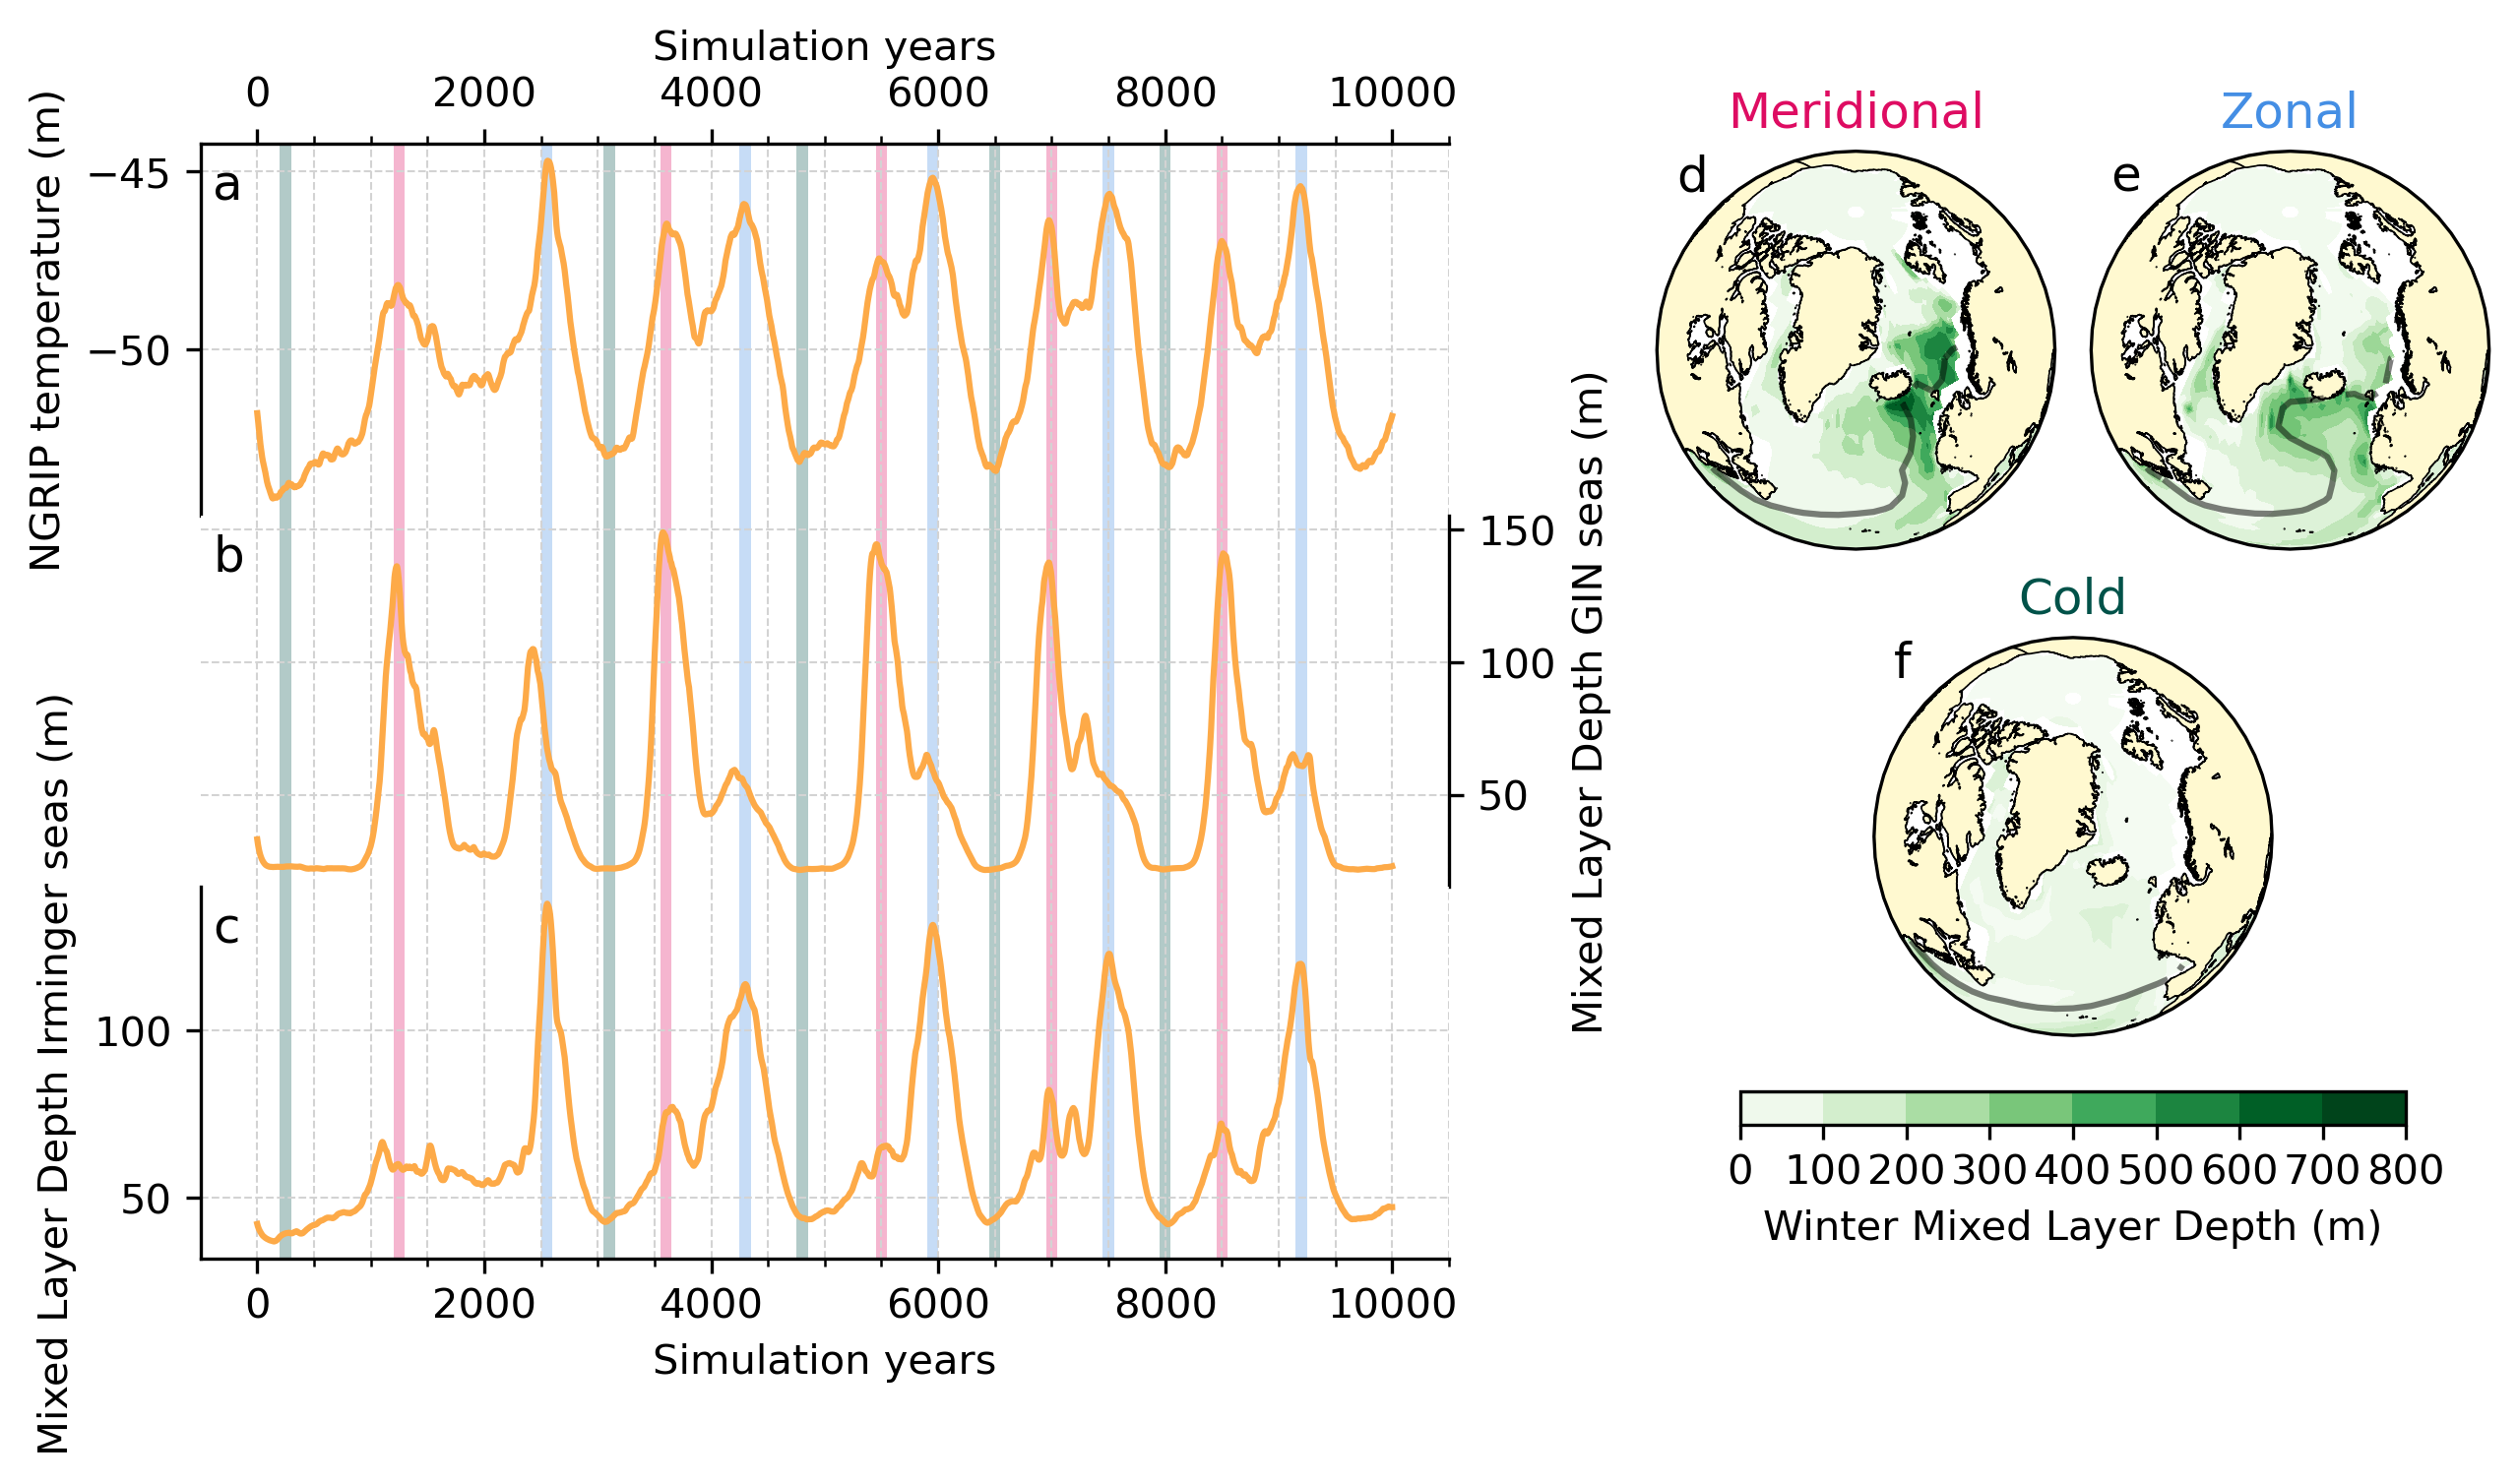

In [41]:
projection_map = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=70, satellite_height=3000000)
fig = plt.figure(figsize=(10,5), dpi=300)

grid = fig.add_gridspec(3, 2, width_ratios=[3,2], hspace=0)
axNGRIP = fig.add_subplot(grid[0,0])
axGIN = fig.add_subplot(grid[1,0])
axIRM = fig.add_subplot(grid[2,0])

gridMLD = grid[:,1].subgridspec(2, 4, wspace=0.2, hspace=0.2)
axMLDMer = fig.add_subplot(gridMLD[0,0:2], projection=projection_map)
axMLDZon = fig.add_subplot(gridMLD[0,2:4], projection=projection_map)
axMLDCld = fig.add_subplot(gridMLD[1,1:3], projection=projection_map)

colors_mode = {'meridional':'xkcd:cerise', 'zonal':'xkcd:dark sky blue', 'cold':'xkcd:dark blue green'}

# Time series

axNGRIP.plot(ngrip.processed_time(start_dates[expt]), ngripf, color=colors[expt])
axNGRIP.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axNGRIP.xaxis.set_minor_locator(AutoMinorLocator())
axNGRIP.xaxis.set_ticks_position('top')
axNGRIP.xaxis.set_label_position('top')
axNGRIP.set_xlabel("Simulation years")
axNGRIP.spines['right'].set_visible(False)
axNGRIP.spines['bottom'].set_visible(False)
axNGRIP.set_ylabel("NGRIP temperature (m)")

axGIN.plot(mld_gin[expt].processed_time(start_dates[expt]), mldf_gin[expt], color=colors[expt])
axGIN.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axGIN.xaxis.set_minor_locator(AutoMinorLocator())
axGIN.tick_params(axis='x', colors='None', which="both")
axGIN.spines['left'].set_visible(False)
axGIN.spines['top'].set_visible(False)
axGIN.spines['bottom'].set_visible(False)
axGIN.set_ylabel("Mixed Layer Depth GIN seas (m)")
axGIN.yaxis.set_ticks_position('right')
axGIN.yaxis.set_label_position('right')

axIRM.plot(mld_irm[expt].processed_time(start_dates[expt]), mldf_irm[expt], color=colors[expt])
axIRM.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axIRM.xaxis.set_minor_locator(AutoMinorLocator())
axIRM.set_xlabel("Simulation years")
axIRM.spines['right'].set_visible(False)
axIRM.spines['top'].set_visible(False)
axIRM.set_ylabel("Mixed Layer Depth Irminger seas (m)")

for ax in [axNGRIP, axIRM, axGIN]:
    for i in range(len(span['meridional'])):
        ax.axvspan(span['meridional'][i]-1000-50, span['meridional'][i]-1000+50, color=colors_mode['meridional'],
                   linewidth=0, alpha=0.3)
    for i in range(len(span['zonal'])):
        ax.axvspan(span['zonal'][i]-1000-50, span['zonal'][i]-1000+50, color=colors_mode['zonal'], 
                   linewidth=0, alpha=0.3)
    for i in range(len(span['cold'])):
        ax.axvspan(span['cold'][i]-1000-50, span['cold'][i]-1000+50, color=colors_mode['cold'],
                   linewidth=0, alpha=0.3)


# MLD summaries
        
normMLD = plots.Normalize(in_values=[mld_mode[mode] for mode in ['meridional', 'zonal','cold']])

cmap=axMLDMer.contourf(lon_ocn, lat_ocn, mld_mode['meridional'], cmap='Greens', norm=normMLD, transform=ccrs.PlateCarree())
axMLDMer.contour(lon_ice, lat_ice, wice_mode['meridional'],levels=[0.5], alpha=0.5, colors='black', transform=ccrs.PlateCarree())
axMLDMer.add_feature(lgm_feature, zorder=1)
axMLDMer.set_global()
axMLDMer.set_title("Meridional", color=colors_mode['meridional'])

axMLDZon.contourf(lon_ocn, lat_ocn, mld_mode['zonal'], cmap='Greens', norm=normMLD, transform=ccrs.PlateCarree())
axMLDZon.contour(lon_ice, lat_ice, wice_mode['zonal'],levels=[0.5], alpha=0.5, colors='black', transform=ccrs.PlateCarree())
axMLDZon.add_feature(lgm_feature, zorder=1)
axMLDZon.set_global()
axMLDZon.set_title("Zonal", color=colors_mode['zonal'])

axMLDCld.contourf(lon_ocn, lat_ocn, mld_mode['cold'], cmap='Greens', norm=normMLD, transform=ccrs.PlateCarree())
axMLDCld.contour(lon_ice, lat_ice, wice_mode['cold'],levels=[0.5], alpha=0.5, colors='black', transform=ccrs.PlateCarree())
axMLDCld.add_feature(lgm_feature, zorder=1)
axMLDCld.set_global()
axMLDCld.set_title("Cold", color=colors_mode['cold'])

fig.colorbar(cmap, label='Winter Mixed Layer Depth (m)', pad=0.05, shrink=0.8,
             ax=[axMLDMer, axMLDZon, axMLDCld], location='bottom')


axNGRIP.annotate('a', xy=(0.01,0.85), xycoords='axes fraction', size=12)
axGIN.annotate('b', xy=(0.01,0.85), xycoords='axes fraction', size=12)
axIRM.annotate('c', xy=(0.01,0.85), xycoords='axes fraction', size=12)
axMLDMer.annotate('d', xy=(0.05,0.9), xycoords='axes fraction', size=12)
axMLDZon.annotate('e', xy=(0.05,0.9), xycoords='axes fraction', size=12)
axMLDCld.annotate('f', xy=(0.05,0.9), xycoords='axes fraction', size=12)

In [42]:
# fig.savefig('Figures/convection.pdf', bbox_inches='tight', format='pdf')

### Figure 8 - Model-DO comparision

In [43]:
# Import NGRIP and EPICA SAT values

ngrip, epica = {}, {}

for expt in ['tfgbi', 'xoupf', 'tfgbj']:
    ngrip[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
    epica[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=-75, mode_lon="value", value_lon=123)
ngrip['tfgbr'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon=318)
epica['tfgbr'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=-75, mode_lon="value", value_lon=123)

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 123.75
____ New latitude value : -75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupf between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ 

In [44]:
# Produce the filtered time series

filt, psd, fq, harm, fc, ngripf, epicaf = {}, {}, {}, {}, {}, {}, {}

for expt in ['tfgbi', 'tfgbr', 'xoupf', 'tfgbj']:
    psd[expt], fq[expt] = util.psd(ngrip[expt].values(), fs=1, scale_by_freq=True)
    harm[expt] = np.where(fq[expt]<=10**-1)
    fc[expt] = util.fundamental_fq(psd[expt], fq[expt])
    filt[expt] = util.ButterLowPass(order=1, fc=2*10**-3, fs=1, mult=2)
    
    ngripf[expt] = filt[expt].process(ngrip[expt].values())
    epicaf[expt] = filt[expt].process(epica[expt].values())

In [45]:
print(f"20.7k - Dominant frequency : {fc['tfgbi']*1000:.4g} kyr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}, " + 
      f"periodicity : {1/fc['tfgbi']/1000:.4g} kyr, " + 
      f"amplitude: {np.max(ngripf['tfgbi']) - np.min(ngripf['tfgbi']):.4g} °C")
print(f"19.4k - Dominant frequency : {fc['tfgbr']*1000:.4g} kyr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}, " + 
      f"periodicity : {1/fc['tfgbr']/1000:.4g} kyr, " + 
      f"amplitude: {np.max(ngripf['tfgbr']) - np.min(ngripf['tfgbr']):.4g} °C")
print(f"18.2k - Dominant frequency : {fc['xoupf']*1000:.4g} kyr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}, " + 
      f"periodicity : {1/fc['xoupf']/1000:.4g} kyr, " + 
      f"amplitude: {np.max(ngripf['xoupf']) - np.min(ngripf['xoupf']):.4g} °C")
print(f"17.8k - Dominant frequency : {fc['tfgbj']*1000:.4g} kyr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}, " + 
      f"periodicity : {1/fc['tfgbj']/1000:.4g} kyr, " + 
      f"amplitude: {np.max(ngripf['tfgbj']) - np.min(ngripf['tfgbj']):.4g} °C")

20.7k - Dominant frequency : 0.5999 kyr⁻¹, periodicity : 1.667 kyr, amplitude: 10.29 °C
19.4k - Dominant frequency : 0.6999 kyr⁻¹, periodicity : 1.429 kyr, amplitude: 10.02 °C
18.2k - Dominant frequency : 0.7999 kyr⁻¹, periodicity : 1.25 kyr, amplitude: 7.337 °C
17.8k - Dominant frequency : 0.6001 kyr⁻¹, periodicity : 1.666 kyr, amplitude: 9.49 °C


In [46]:
# The first hundred years are not taken into account

print(f" 20.7k - Warming rate : {np.max(np.diff(ngripf['tfgbi'])[100:])*100:.4g} °C/100yr, " + 
      f"Cooling rate : {np.min(np.diff(ngripf['tfgbi'])[100:])*100:.4g} °C/100yr")
print(f" 19.4k - Warming rate : {np.max(np.diff(ngripf['tfgbr'])[100:])*100:.4g} °C/100yr, " + 
      f"Cooling rate : {np.min(np.diff(ngripf['tfgbr'])[100:])*100:.4g} °C/100yr")
print(f" 18.2k - Warming rate : {np.max(np.diff(ngripf['xoupf'])[100:])*100:.4g} °C/100yr, " + 
      f"Cooling rate : {np.min(np.diff(ngripf['xoupf'])[100:])*100:.4g} °C/100yr")
print(f" 17.8k - Warming rate : {np.max(np.diff(ngripf['tfgbj'])[100:])*100:.4g} °C/100yr, " + 
      f"Cooling rate : {np.min(np.diff(ngripf['tfgbj'])[100:])*100:.4g} °C/100yr")

 20.7k - Warming rate : 4.935 °C/100yr, Cooling rate : -3.976 °C/100yr
 19.4k - Warming rate : 5.187 °C/100yr, Cooling rate : -3.715 °C/100yr
 18.2k - Warming rate : 2.841 °C/100yr, Cooling rate : -3.573 °C/100yr
 17.8k - Warming rate : 4.166 °C/100yr, Cooling rate : -5.281 °C/100yr


In [47]:
# Import proxy records between 44,000 and 40,000 ka BP

names_NGRIP = ['age', 'O18']
proxy_ngrip = pd.read_excel(f"{data_folder}/proxies/41586_2004_BFnature02805_MOESM1_ESM.xlsx", sheet_name='Data', names=names_NGRIP, na_values=['NAN'])
proxy_ngrip = proxy_ngrip.where(proxy_ngrip.age>=40000*1000).where(proxy_ngrip.age<=44000*1000)

names_EDML = ['age', 'O18']
proxy_edml = pd.read_excel(f"{data_folder}/proxies/EDML_d18O.xlsx", sheet_name='Data_simple', names=names_EDML, na_values=['NAN'])
proxy_edml = proxy_edml.where(proxy_edml.age>=40000/1000).where(proxy_edml.age<=44000/1000)

Text(0.01, 0.15, 'd')

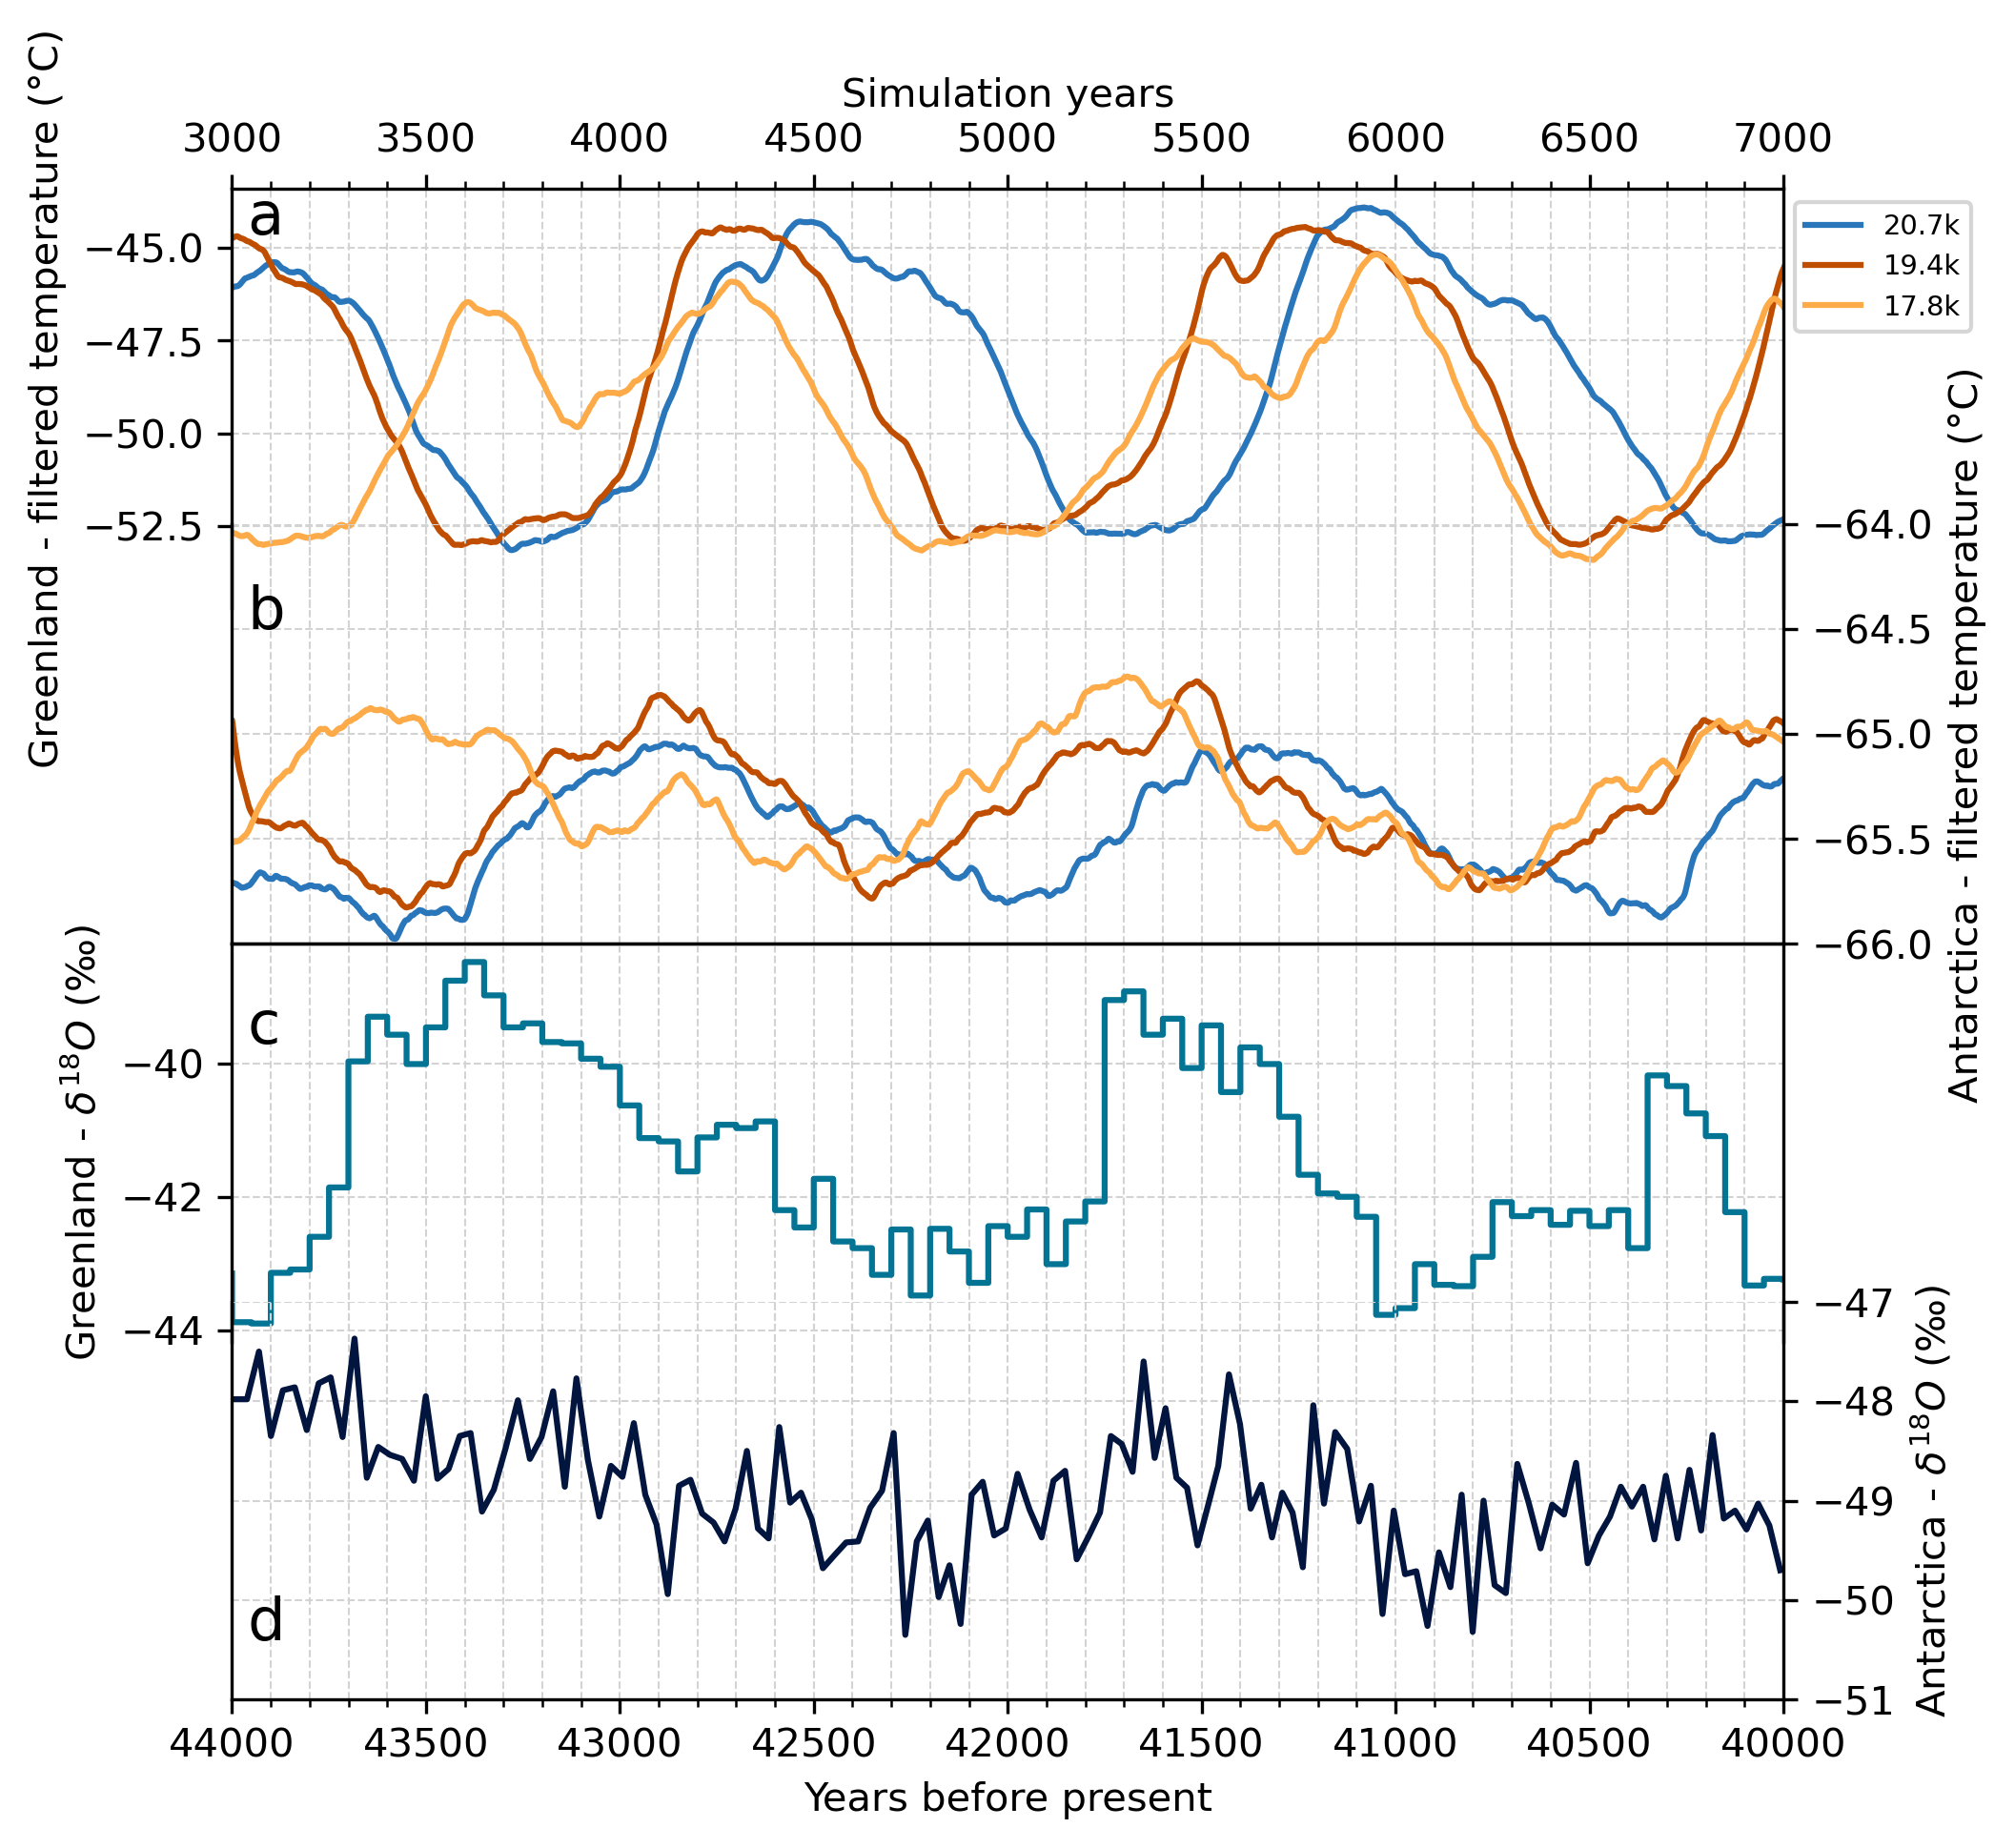

In [48]:
figMap = plt.figure(figsize=(7, 7), dpi=300)

grid = figMap.add_gridspec(nrows=2, ncols=1, hspace=0)
gridModel = grid[0].subgridspec(2, 1, hspace=-0.2)
axNGRIP= figMap.add_subplot(gridModel[0],facecolor='None')
axEPICA= figMap.add_subplot(gridModel[1],facecolor='None', sharex=axNGRIP)

gridData = grid[1].subgridspec(2, 1, hspace=-0.1)
axNGRIPD= figMap.add_subplot(gridData[0],facecolor='None')
axEPICAD= figMap.add_subplot(gridData[1],facecolor='None', sharex=axNGRIPD)

for expt in ['tfgbi', 'tfgbr', 'tfgbj']:
    axNGRIP.plot(ngrip[expt].processed_time(start_dates[expt]), ngripf[expt], color=colors[expt], linestyle="-", label=labels[expt])
    axEPICA.plot(epica[expt].processed_time(start_dates[expt]), epicaf[expt], color=colors[expt], linestyle="-")

axNGRIP.spines['bottom'].set_visible(False)
axNGRIP.set_ylabel('Greenland - filtered temperature (°C)')
axNGRIP.set_xlim(3000, 7000)
axNGRIP.xaxis.set_ticks_position('top')
axNGRIP.set_xlabel("Simulation years")
axNGRIP.xaxis.set_label_position('top')
axNGRIP.xaxis.set_minor_locator(AutoMinorLocator())
axNGRIP.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axNGRIP.legend(fontsize='x-small', loc='upper right', bbox_to_anchor=(1.13, 1))
axNGRIP.annotate('a', xy=(0.01,0.89), xycoords='axes fraction', size=15)

axEPICA.spines['top'].set_visible(False)
axEPICA.tick_params(axis='x', colors='None', which='both')
axEPICA.xaxis.set_minor_locator(AutoMinorLocator())
axEPICA.set_ylim(-66, -64)
axEPICA.yaxis.set_ticks_position('right')
axEPICA.yaxis.set_label_position('right')
axEPICA.set_ylabel("Antarctica - filtered temperature (°C)")
axEPICA.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axEPICA.annotate('b', xy=(0.01,0.75), xycoords='axes fraction', size=15)

axNGRIPD.plot(proxy_ngrip.age/1000, proxy_ngrip.O18, color='xkcd:sea blue')
axEPICAD.plot(proxy_edml.age*1000, proxy_edml.O18, color='xkcd:navy')

axNGRIPD.spines['bottom'].set_visible(False)
axNGRIPD.set_ylabel('Greenland - $\delta^{18}O$ (‰)')
axNGRIPD.set_xlim(44000, 40000)
axNGRIPD.xaxis.set_ticks_position('top')
axNGRIPD.tick_params(axis='x', colors='None', which='both')
axNGRIPD.xaxis.set_label_position('top')
axNGRIPD.xaxis.set_minor_locator(AutoMinorLocator())
axNGRIPD.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axNGRIPD.annotate('c', xy=(0.01,0.75), xycoords='axes fraction', size=15)

axEPICAD.spines['top'].set_visible(False)
axEPICAD.xaxis.set_minor_locator(AutoMinorLocator())
axEPICAD.set_ylim(-51, -47)
axEPICAD.set_xlabel("Years before present")
axEPICAD.yaxis.set_ticks_position('right')
axEPICAD.yaxis.set_label_position('right')
axEPICAD.set_ylabel(r"Antarctica - $\delta^{18}O$ (‰)")
axEPICAD.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axEPICAD.annotate('d', xy=(0.01,0.15), xycoords='axes fraction', size=15)

In [49]:
# figMap.savefig('Figures/see_saw.pdf', bbox_inches='tight', format='pdf')